# Notebook to reproduce figures of Klimek et. al PRX Life 2025

In order to fit the respective GLE model to the data, the functions optimize_all_cells_[model_name]_ ind (input_vacf, ...) are used. These functions can be found in the file "tools_opt_prw_sim.py".
When reproducing the optimized parameters, they can slightly differ from the saved optimal parameters depending on the number of averages in the fit and the initial parameter guess.
Artificial distributions with a given value of $S$ are created by the functions sim_var_[model_name](experimental_distribution, S, ...), which is also found in the file "tools_opt_prw_sim.py".
The statistical permutation test is performed by the function cov_test_scaling(experimental_distribution, S, ...), also defined in "tools_opt_prw_sim.py" .
When using any of the code, please cite Klimek et al PRX Life 2025.

In [26]:
# import packages for analysis
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# import plotting packages
import matplotlib.cm as cm
import mpltex
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# for labels of subfigures
alphabet = list(map(chr, range(97, 123)))

# import functions from self-written code
from motility import *
from tools_opt_prw_sim import *
from correlation_functions_expos import *


# define the p-values that are obtained by the statistical test

# p-values can be loaded by:
# load_pvals('./mb231_optimize', 'indi_cov', test='', mean_str='_med')
# load_pvals('./test_method', 'beads_corrected_fD08_msd', test='') #is 2d, but not in name
# load_pvals('./chlamy_optimize', 'locfitsyn_sc_2d', mean_str='_med', test='', idx=100, n_real=100, alpha=0.05)

pvals_beads = np.array([0.99, 0.81, 0.36, 0.1, 0.07, 0.07, 0, 0.02, 0.01, 0, 0, 0, 0, 0.01, 0.03, 0.04, 0.05, 0.04, 0.1, 0.15, 0.21])
percent_beads = np.array([0, 0.1, 0.2, 0.3, 0.31, 0.33, 0.35, 0.37, 0.4, 0.43, 0.5, 0.53, 0.56, 0.6, 0.7, 0.72, 0.75, 0.77, 0.8, 0.9, 1])

pvals_syn = np.array([1, 0.9, 0.8, 0.58, 0.45, 0.22, 0.19, 0.1, 0.08, 0.07, 0.07, 0.08, 0.04, 0.03, 0.04, 0.05, 0])
percent_syn = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1])

pvals_mb231 = np.array([1, 1, 0.97, 0.69, 0.46, 0.23, 0.09, 0.06, 0.03, 0.02, 0.01, 0, 0])
percent_mb231 = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.64, 0.66, 0.7, 0.8, 0.9, 1])

## Load 1000nm polystyrene beads data in water and extract correlation functions and effective memory kernel

In [27]:
path_1000nm = '230821-PS1000-Bulk_1_MMStack_Default.tracks_v2_sub_drift.50.dat.mat' # .mat file that contains tracking data
dict_1000nm, x_beads, y_beads = calc_dict_from_data(path_1000nm, 'lengths_trj_1000nm_water_corrected.npy', 60, 1/50.41, 0.13, filter_agree=False, filter_corr=0, return_pos=True) # if no file with lengths is given, then one is created with the given name

vxscale_beads = combine_fun(scale_v, dict_1000nm['vx']) # to check Gaussianity on single-cell level
vyscale_beads = combine_fun(scale_v, dict_1000nm['vy'])
mean_kern_1000nm = kernel_1dcc(np.mean(0.5 * (dict_1000nm['cvvx'] + dict_1000nm['cvvy']), axis=0), 1/50.41)
var_vxy_beads = np.std((dict_1000nm['vx'] + dict_1000nm['vy'])/2, axis=1)

/home/kanton/miniconda3/envs/main/lib/python3.9/site-packages/numpy/ma/core.py:1178: RuntimeWarning: invalid value encountered in multiply
  masked_da = umath.multiply(m, da)


## Load Chlamydomonas synchro trajectories (see Klimek et al Biophys. J. 2024) and extract correlation functions, effective kernel, msd, etc.

In [28]:
from chlamy_load_save import load_data_ordered
xsall, ysall = load_data_ordered(23, 6943, './H10 Synchronous', 'S') # position data as masked matrices

vxall_s = combine_fun(lambda x: np.diff(x)/0.002, xsall, lmodified=1) # compute discrete derivative velocity over time for every row (every cell)
vyall_s = combine_fun(lambda x: np.diff(x)/0.002, ysall, lmodified=1)

vxacf_s = combine_fun(correlation, vxall_s) # autocorrelation
vyacf_s = combine_fun(correlation, vyall_s)

kernelx_s = combine_fun(lambda x: kernel_1dcc(x, 0.002), vxacf_s, lmodified=2) # extract effective kernel for individual cells
kernely_s = combine_fun(lambda x: kernel_1dcc(x, 0.002), vyacf_s, lmodified=2)
kernel_av_s = combine_fun(lambda x: kernel_1dcc(x, 0.002), (vxacf_s + vyacf_s) / 2, lmodified=2)

vscale_synx = combine_fun(scale_v, vxall_s) # subtract mean and divide by variance to determine single-cell gaussianity
vscale_syny = combine_fun(scale_v, vyall_s)

msds = combine_fun2(lambda x,y: tidynamics.msd(x) + tidynamics.msd(y), xsall, ysall) # MSD in 2D (directions are independent of each other)

mean_kern_s = kernel_1dcc(np.mean(0.5 * (vxacf_s + vyacf_s), axis=0), 0.002) # mean kernel for Fig. 3
var_vxy_s = np.std((vxall_s + vyall_s) / 2, axis=1)

## Load breast cancer trajectory data (1D) and extract correlation functions etc.

In [29]:
from load_cancer import load_data_cancer_ordered

i20 = 136 # number of trajectories
l20 = 2161 # maximum length among trajectories (in steps)
path = './Fibronectin_surface'
# path = '/home/kanton/Doktor/Cell_Data/New/Fibronectin_surface'
file = 'MDA-MB-231-H2B-mCherry_20s_alltracks_combined'
xt20, yt20, dent20, lant20, ltrjt20 = load_data_cancer_ordered(i20,l20,path,file) # x-position, y-position on the lane (constant since 1D), density of fibronectin at position, lane number, trajectory length

vall20_cut = combine_fun(lambda x:np.diff(x)*3, xt20, lmodified=1) # cut is just in the name for historical reasons
var_v_all20_cut = np.std(vall20_cut, axis=1)

v_scale_all20_cut = combine_fun(scale_v, vall20_cut)
vacf_all20_cut = combine_fun(correlation, vall20_cut)
kernel_all20_cut = combine_fun(lambda x:kernel_1dcc(x, 1/3), vacf_all20_cut, lmodified=2) # lmodified=2 because the extracted kernel length is 2 less than the input vacf because of finite derivatives
msdx_all20_cut = combine_fun(lambda x: msd_fast(x), xt20)

mean_kern_all20_cut = kernel_1dcc(np.mean(vacf_all20_cut, axis=0), 1/3)

### Load length distributions of trajectories

In [30]:
lall_mb = np.load('./mb231_optimize/lall_mb231_dt03.npy')
lall_beads = np.load('diffusion_1000nm_water_lens_av200_msd_idx10_filtD.npy')
lall_syn = np.load('./chlamy_optimize/lall_syn.npy')

print(np.mean(lall_mb), np.median(lall_mb), np.min(lall_mb))
print(np.mean(lall_beads), np.median(lall_beads), np.min(lall_beads))
print(np.mean(lall_syn), np.median(lall_syn), np.min(lall_syn))

328.10370370370373 199.0 93.0
554.8134328358209 222.5 61.0
4025.304347826087 4105.0 2393.0


## Load optimized GLE-model parameters (caution since order of  trajectories and correlation functions is 1,2,3, whereas optimal parameters are ordered according to the following lists)

In [31]:
indices_opt_cancer = [95, 66, 111, 12, 98, 42, 21, 126, 34, 51, 61, 18, 99, 38, 107, 33, 88, 119, 0, 19, 80, 70, 76, 57, 131, 97, 54, 13, 122, 62, 120, 72, 85, 78, 79, 64, 127, 6, 103, 112, 115, 134, 123, 37, 7, 41, 105, 69, 81, 10, 5, 35, 59, 75, 108, 29, 89, 58, 30, 74, 53, 82, 17, 36, 1, 93, 39, 11, 114, 101, 20, 27, 110, 44, 15, 77, 50, 46, 109, 23, 130, 16, 14, 86, 9, 87, 25, 68, 71, 106, 56, 128, 40, 31, 63, 90, 48, 49, 60, 91, 32, 47, 104, 73, 26, 118, 67, 125, 117, 3, 83, 96, 2, 45, 102, 4, 132, 124, 24, 43, 121, 84, 65, 8, 28, 116, 55, 52, 94, 133, 100, 113, 92, 129,22]
indices_opt_syn = [18, 19, 6, 17, 11, 4, 3, 21, 8, 15, 12, 13, 16, 22, 20, 10, 9, 1, 23, 14, 5, 2, 7] # starts from 1
# beads are in correct order

In [32]:
opt_beads_raw = np.load('./diffusion_1000nm_water_optis_av1000_msd_idx10_Dlim1105_raw.npy')

filt_inds_beads = filt_distr(opt_beads_raw, 0.001, 0.2)
print(len(filt_inds_beads), len(opt_beads_raw))
inds_fd08 = np.where(opt_beads_raw[filt_inds_beads, 0] < 0.8)[0]
opt_beads_filt = opt_beads_raw[filt_inds_beads, :][inds_fd08]

opt_mb231 = np.load('./mb231_optimize/indioptprwmb231_av1000_Bmax4_tmmax4_errmax1.0_ind10_dt0.3.npy')
filt_mb231 = filt_distr(opt_mb231, 0.01, 1)
print(len(opt_mb231), len(filt_mb231))

opt_syn = np.load('./s0xyopt_osckern_params_syn_tgmax5_fmax220_errm005_av1005_ind100.npy')

125 144
135 131


## Determine goodness of fit R^2 value (eq. S5 in SI)

In [33]:
rsq_beads = np.zeros(len(opt_beads_filt))
for ind in range(len(opt_beads_filt)):
    msd_ex = dict_1000nm['msd'][filt_inds_beads, :][inds_fd08, :][ind, :10].compressed()
    tb = np.arange(len(msd_ex)) / 50.41
    msd_fit = 2 * msd_diffusion_noise(*opt_beads_filt[ind, :] , tb[:10])
    rsq_beads[ind] = r2_score(msd_ex, msd_fit)

rsq_mb231 = np.zeros(len(opt_mb231))
for ind in range(len(opt_mb231)):
    vacf_ex = vacf_all20_cut[indices_opt_cancer[ind], :10]
    tb = np.arange(len(vacf_ex) + 2) / 3
    vacf_fit = vacf_noise_prw(*opt_mb231[ind, :] , tb[:11], msd=msd_prw)
    rsq_mb231[ind] = r2_score(vacf_ex, vacf_fit)

rsq_syn = np.zeros(len(opt_syn))
for ind in range(len(opt_syn)):
    vacf_ex = 0.5 * (vxacf_s[indices_opt_syn[ind] - 1, :100].compressed() + vyacf_s[indices_opt_syn[ind] - 1, :100].compressed()) # indices_opt_syn[ind] - 1 , since naming starts from S1.txt
    tb = np.arange(len(vacf_ex) + 2) / 500
    vacf_fit = vacf_noise_osc(*opt_syn[ind, :] , tb[:101], msd=msd_osc_sincos)
    rsq_syn[ind] = r2_score(vacf_ex, vacf_fit)

# Fig 1

length beads:  23.66593929775838 inset:  1.646498710573299
length cancer: 64.66666666666667
length CR 12.426


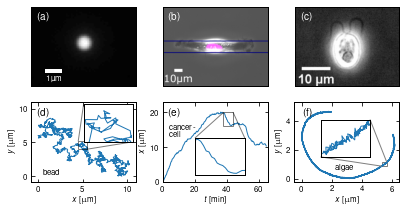

In [34]:
@mpltex.acs_decorator
def plot_trj():
    fig, ax = plt.subplots(2, 3) #, dpi=1200

    pixvals = np.array(Image.open('./beads_image_2.png').convert('L'))
    pixvals = ((pixvals - pixvals.min()) / (pixvals.max()-pixvals.min())) * 255

    img = Image.fromarray(pixvals.astype(np.uint8))
    ax[0, 0].imshow(img, cmap='gray')
    ax[0, 0].plot([10, 10 + 1/0.13], [40, 40], lw=4, c='white')

    ax[0, 0].text(9, 46, '1$\,$µm', color='white')

    ax[0, 0].set_xlim(0, img.size[0]-1)
    ax[0, 0].set_ylim(img.size[1]-1, 0)
    ax[0, 0].set_xticks([])
    ax[0, 0].set_yticks([])

    img = np.asarray(Image.open('./cell-on-lane_blue.png')) #.rotate(-90, expand=True)

    ax[0, 1].imshow(img)

    ax[0, 1].set_xticks([])
    ax[0, 1].set_yticks([])

    img = np.asarray(Image.open('./synchro_snap.png'))
    ax[0, 2].imshow(img)

    ax[0, 2].set_xticks([])
    ax[0, 2].set_yticks([])

    ind_b = 0
    xtrj = x_beads[ind_b, :].compressed() - min(x_beads[ind_b, :].compressed())
    ytrj = y_beads[ind_b, :].compressed() - min(y_beads[ind_b, :].compressed())
    ax[1, 0].plot(xtrj, ytrj)

    axins = ax[1, 0].inset_axes([0.5, 0.5, 0.47, 0.47])
    # sub region of the original image
    x1, x2, y1, y2 = 4.5, 5.5, 4, 5.2
    axins.plot(xtrj[np.where((xtrj < x2) & (xtrj > x1))[0]], ytrj[np.where((xtrj < x2) & (xtrj > x1))[0]])
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticks([])
    axins.set_yticks([])
    ax[1, 0].indicate_inset_zoom(axins, edgecolor="black")

    ax[1, 0].set_xlabel(r'$x$ [$\mu \rm{m}$]')
    ax[1, 0].set_ylabel(r'$y$ [$\mu \rm{m}$]')
    ax[1, 0].set_xlim(-0.8, 11)
    ax[1, 0].set_ylim(-0.8, 11)
    print('length beads: ', len(xtrj) / 50.41, 'inset: ', len(np.where((xtrj < x2) & (xtrj > x1))[0]) / 50.41)


    ind_cancer = 95 #105 # trajectory with name ending 95 in file name
    t = np.arange(len(xt20[ind_cancer, :].compressed())) / 3
    ax[1, 1].plot(t, xt20[ind_cancer, :].compressed() - min(xt20[ind_cancer, :].compressed()))

    axins = ax[1, 1].inset_axes([0.31, 0.08, 0.47, 0.47])
    axins.plot(t[100:150], xt20[ind_cancer, 100:150].compressed() - min(xt20[ind_cancer, :].compressed()))
    # sub region of the original image
    x1, x2, y1, y2 = 38, 44, 16, 20
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticks([])
    axins.set_yticks([])
    ax[1, 1].indicate_inset_zoom(axins, edgecolor="black")

    ax[1, 1].set_xlabel(r'$t$ [$\rm{min}$]')
    ax[1, 1].set_ylabel(r'$x$ [$\mu \rm{m}$]')
    ax[1, 1].set_xlim(0, max(t) + 1)
    ax[1, 1].set_ylim(0, 23)
    print('length cancer:', max(t))




    # ind_s = 12
    ind_s = indices_opt_syn[8] - 1 # 12, inset_axes([0.44, 0.19, 0.44, 0.44]), x1, x2, y1, y2 = 0.85, 1.025, 2.12, 2.26, 4100:4200
    ax[1, 2].plot(xsall[ind_s,:] - np.min(xsall[ind_s,:]), ysall[ind_s,:] - np.min(ysall[ind_s,:]))
    axins = ax[1, 2].inset_axes([0.25, 0.31, 0.47, 0.47])
    ind_start = 5200
    axins.plot(xsall[ind_s,ind_start:ind_start+150] - np.min(xsall[ind_s,:]), ysall[ind_s,ind_start:ind_start+150] - np.min(ysall[ind_s,:]))
    # # sub region of the original image
    # x1, x2, y1, y2 = 10.5, 11.8, 19, 19.4
    x1, x2, y1, y2 = 5.34, 5.65, 0.86, 1.15
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticks([])
    axins.set_yticks([])

    print('length CR', len(xsall[ind_s,:].compressed()) * 0.002)
    mark_inset(ax[1, 2], axins, loc1=3, loc2=1, ec='0.5')

    ax[1, 2].set_xlabel(r'$x$ [$\mu \rm{m}$]')
    ax[1, 2].set_ylabel(r'$y$ [$\mu \rm{m}$]')
    ax[1, 2].set_xlim(-0.5, 6.5)
    ax[1, 2].set_ylim(-0.2, 5.3)

    ax[1, 0].text(0.5, 0.3, r'$\rm{bead}$')
    ax[1, 1].text(4, 15, r'$\rm{cancer}$-')
    ax[1, 1].text(4, 13, r'$\rm{cell}$')
    ax[1, 2].text(2.24, 0.6, r'$\rm{algae}$')
    ax[1, 2].set_xticks([0, 2, 4, 6])

    k = 0
    for i in range(2):
        for j in range(3):
            if i == 0:
                ax[i, j].text(0.17, 0.87, '(' + alphabet[k] + ')',
                    horizontalalignment='right',
                    verticalalignment='center',
                    color='white',
                    rotation=0,
                    fontsize=10,
                    transform=ax[i, j].transAxes)

            else:
                ax[i, j].text(0.17, 0.87, '(' + alphabet[k] + ')',
                    horizontalalignment='right',
                    verticalalignment='center',
                    rotation=0,
                    fontsize=10,
                    transform=ax[i, j].transAxes)
            k += 1

    plt.subplots_adjust(wspace=0.25, hspace=0.2, right=1.7, top=1.2)
    # print(fig.get_size_inches() * ax[0, 0].get_position().size)



    plt.show()
plot_trj()

# Fig 2

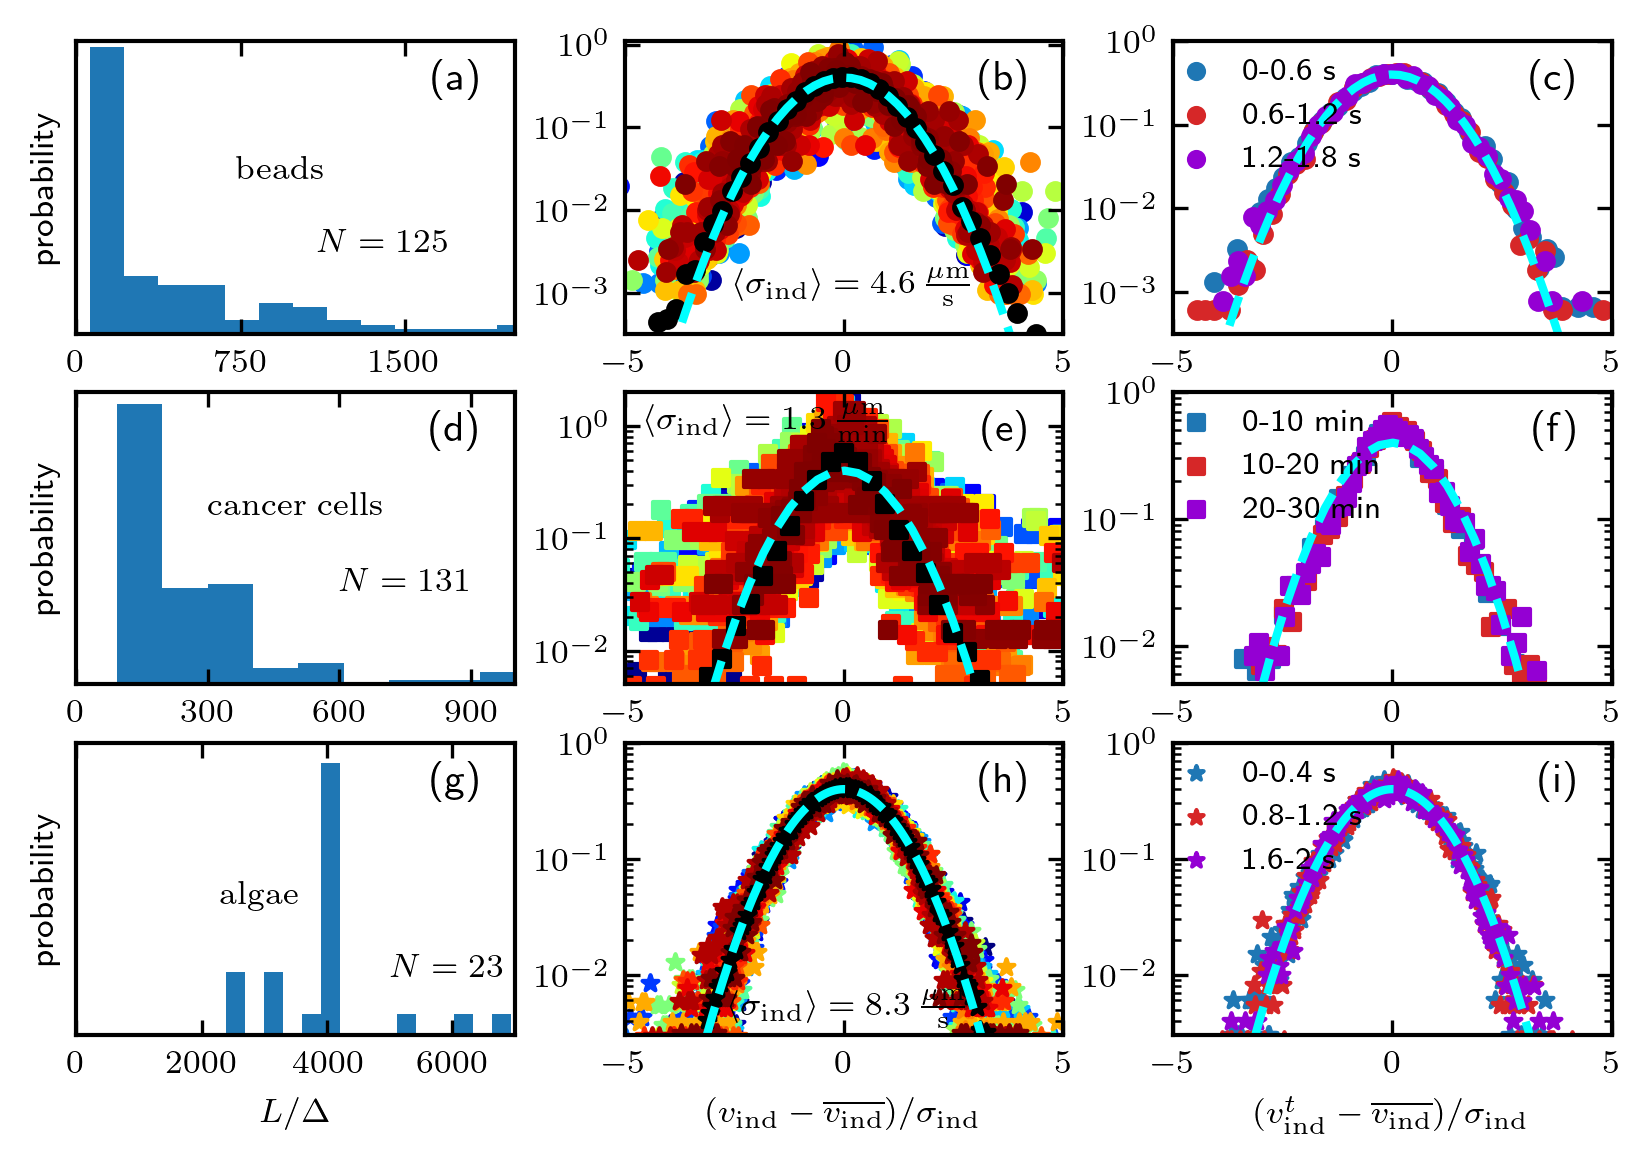

In [35]:
@mpltex.acs_decorator
def plot_lens_vels():
    fig, ax = plt.subplots(3, 3, dpi=300)
    ax[0, 0].hist(lall_beads, bins=20, density=True)
    # ax[0, 0].set_xlabel('length [s]')
    ax[0, 0].set_ylabel('probability')
    #125

    ax[1, 0].hist(lall_mb, bins=20, density=True)
    # ax[1, 0].set_xlabel('length [min]')
    ax[1, 0].set_ylabel('probability')
    #131

    ax[2, 0].hist(lall_syn, bins=15, density=True)
    ax[2, 0].set_xlabel(r'$L/\Delta$')
    ax[2, 0].set_ylabel('probability')
    #23
    
    
    vals_scale_all, bins_scale_all = np.histogram(np.append(vxscale_beads.compressed(), vyscale_beads.compressed()), bins=50, density=True)
    mean_bins_scale_all = 0.5 * (bins_scale_all + np.roll(bins_scale_all, -1))[:-1]


    colors = [cm.jet(x) for x in np.linspace(0, 1, len(vxscale_beads[:, 0]))]
    for j in range(len(vxscale_beads[:, 0])):
        vx = np.append(vxscale_beads[j, :].compressed(), vyscale_beads[j, :].compressed())
        
        val_prob_vxyw_scale, bins_vxyw_scale = np.histogram((vx-np.mean(vx))/np.std(vx), bins=50, density=True) # [j, :]
        mean_bins_scale = 0.5 * (bins_vxyw_scale + np.roll(bins_vxyw_scale, -1))[:-1]

        ax[0, 1].scatter(mean_bins_scale, val_prob_vxyw_scale, color=colors[j], marker='o')

    
    ax[0, 1].scatter(mean_bins_scale_all, vals_scale_all, c='k')
    ax[0, 1].plot(mean_bins_scale_all, np.exp(-mean_bins_scale_all**2/2)/np.sqrt(2*np.pi), c='cyan',lw=2, ls='dashed')
    # ax[0, 1].set_xlabel(r'$(v_{\rm{ind}}-\overline{v_{\rm{ind}}})/\sigma_{\rm{ind}}$')
    # ax[0, 1].set_ylabel('probability')
    ax[0, 1].set_xlim(-5, 5)
    ax[0, 1].set_ylim(0.00032, 1.1)
    ax[0, 1].set_yscale('log')


    vals_scale_all_30, bins_scale_all_30 = np.histogram(np.append(vxscale_beads[:, :30].compressed(), vyscale_beads[:, :30].compressed()), bins=50, density=True)
    mean_bins_scale_all_30 = 0.5 * (bins_scale_all_30 + np.roll(bins_scale_all_30, -1))[:-1]

    vals_scale_all_60, bins_scale_all_60 = np.histogram(np.append(vxscale_beads[:, 30:60].compressed(), vyscale_beads[:, 30:60].compressed()), bins=50, density=True)
    mean_bins_scale_all_60 = 0.5 * (bins_scale_all_60 + np.roll(bins_scale_all_60, -1))[:-1]

    vals_scale_all_90, bins_scale_all_90 = np.histogram(np.append(vxscale_beads[:, 60:90].compressed(), vyscale_beads[:, 60:90].compressed()), bins=50, density=True)
    mean_bins_scale_all_90 = 0.5 * (bins_scale_all_90 + np.roll(bins_scale_all_90, -1))[:-1]
    
    ax[0, 2].scatter(mean_bins_scale_all_30, vals_scale_all_30, marker='o', label='0-0.6 s')
    ax[0, 2].scatter(mean_bins_scale_all_60, vals_scale_all_60, marker='o', label='0.6-1.2 s')
    ax[0, 2].scatter(mean_bins_scale_all_90, vals_scale_all_90, marker='o', c='darkviolet', label='1.2-1.8 s')
    ax[0, 2].plot(mean_bins_scale_all, np.exp(-mean_bins_scale_all**2/2)/np.sqrt(2*np.pi), c='cyan',lw=2, ls='dashed')
    # ax[0, 2].set_xlabel(r'$(v_{\rm{ind}}^t-\overline{v_{\rm{ind}}})/\sigma_{\rm{ind}}$')
    # ax[0, 2].set_ylabel('probability')
    ax[0, 2].set_xlim(-5, 5)
    ax[0, 2].set_ylim(0.00032, 1)
    ax[0, 2].set_yscale('log')
    ax[0, 2].legend(loc='upper left', bbox_to_anchor=[-0.09, 1.05])



    vals_scale_all, bins_scale_all = np.histogram(v_scale_all20_cut.compressed(), bins=100, density=True)
    mean_bins_scale_all = 0.5 * (bins_scale_all + np.roll(bins_scale_all, -1))[:-1]

    colors = [cm.jet(x) for x in np.linspace(0, 1, len(v_scale_all20_cut[:, 0]))]
    for j in range(len(v_scale_all20_cut[:, 0])):
        vx = v_scale_all20_cut[j, :].compressed()
        
        val_prob_vxyw_scale, bins_vxyw_scale = np.histogram(vx, bins=100, density=True) # np.histogram((vx-np.mean(vx))/np.std(vx), bins=30, density=True) # [j, :]
        mean_bins_scale = 0.5 * (bins_vxyw_scale + np.roll(bins_vxyw_scale, -1))[:-1]

        ax[1, 1].scatter(mean_bins_scale, val_prob_vxyw_scale, color=colors[j], marker='s')

    
    ax[1, 1].scatter(mean_bins_scale_all, vals_scale_all, c='k', marker='s')
    ax[1, 1].plot(mean_bins_scale_all, np.exp(-mean_bins_scale_all**2/2)/np.sqrt(2*np.pi), c='cyan',lw=2, ls='dashed')
    # ax[1, 1].set_xlabel(r'$(v_{\rm{ind}}-\overline{v_{\rm{ind}}})/\sigma_{\rm{ind}}$')
    # ax[1, 1].set_ylabel('probability')
    ax[1, 1].set_xlim(-5, 5)
    ax[1, 1].set_ylim(0.005, 2)
    ax[1, 1].set_yscale('log')


    vals_scale_all_30, bins_scale_all_30 = np.histogram(v_scale_all20_cut[:, :30].compressed(), bins=100, density=True)
    mean_bins_scale_all_30 = 0.5 * (bins_scale_all_30 + np.roll(bins_scale_all_30, -1))[:-1]

    vals_scale_all_60, bins_scale_all_60 = np.histogram(v_scale_all20_cut[:, 30:60].compressed(), bins=100, density=True)
    mean_bins_scale_all_60 = 0.5 * (bins_scale_all_60 + np.roll(bins_scale_all_60, -1))[:-1]

    vals_scale_all_90, bins_scale_all_90 = np.histogram(v_scale_all20_cut[:, 60:90].compressed(), bins=100, density=True)
    mean_bins_scale_all_90 = 0.5 * (bins_scale_all_90 + np.roll(bins_scale_all_90, -1))[:-1]
    
    ax[1, 2].scatter(mean_bins_scale_all_30, vals_scale_all_30, marker='s', label='0-10 min')
    ax[1, 2].scatter(mean_bins_scale_all_60, vals_scale_all_60, marker='s', label='10-20 min')
    ax[1, 2].scatter(mean_bins_scale_all_90, vals_scale_all_90, marker='s', c='darkviolet', label='20-30 min')
    ax[1, 2].plot(mean_bins_scale_all, np.exp(-mean_bins_scale_all**2/2)/np.sqrt(2*np.pi), c='cyan',lw=2, ls='dashed')
    # ax[1, 2].set_xlabel(r'$(v_{\rm{ind}}^t-\overline{v_{\rm{ind}}})/\sigma_{\rm{ind}}$')
    # ax[1, 2].set_ylabel('probability')
    ax[1, 2].set_xlim(-5, 5)
    ax[1, 2].set_ylim(0.005, 1)
    ax[1, 2].set_yscale('log')
    ax[1, 2].legend(loc='upper left', bbox_to_anchor=[-0.09, 1.05])


    vals_scale_all, bins_scale_all = np.histogram(np.concatenate((vscale_synx.compressed(), vscale_syny.compressed())), bins=200, density=True)
    mean_bins_scale_all = 0.5 * (bins_scale_all + np.roll(bins_scale_all, -1))[:-1]


    colors = [cm.jet(x) for x in np.linspace(0, 1, len(vscale_synx))]
    for j in range(len(vscale_synx)):
        vx = np.append(vscale_synx[j, :].compressed(), vscale_syny[j, :].compressed())
        val_prob_vxyw_scale, bins_vxyw_scale = np.histogram(vx, bins=200, density=True) # np.histogram((vx-np.mean(vx))/np.std(vx), bins=30, density=True) # [j, :]
        mean_bins_scale = 0.5 * (bins_vxyw_scale + np.roll(bins_vxyw_scale, -1))[:-1]
        ax[2, 1].scatter(mean_bins_scale, val_prob_vxyw_scale, color=colors[j], marker='*')
    
    ax[2, 1].scatter(mean_bins_scale_all, vals_scale_all, c='k', marker='*')
    ax[2, 1].plot(mean_bins_scale_all, np.exp(-mean_bins_scale_all**2/2)/np.sqrt(2*np.pi), c='cyan',lw=2, ls='dashed')
    ax[2, 1].set_xlabel(r'$(v_{\rm{ind}}-\overline{v_{\rm{ind}}})/\sigma_{\rm{ind}}$')
    # ax[2, 1].set_ylabel('probability')
    ax[2, 1].set_xlim(-5, 5)
    ax[2, 1].set_ylim(0.003, 1)
    ax[2, 1].set_yscale('log')

    # v_scale_all_ws_200 = np.concatenate((vscale_wobx[:,:200].compressed(), vscale_woby[:,:200].compressed(), vscale_synx[:,:200].compressed(), vscale_syny[:,:200].compressed()))
    v_scale_all_ws_200 = np.concatenate((vscale_synx[:,:200].compressed(), vscale_syny[:,:200].compressed()))
    vals_scale_all_200, bins_scale_all_200 = np.histogram(v_scale_all_ws_200, bins=200, density=True)
    mean_bins_scale_all_200 = 0.5 * (bins_scale_all_200 + np.roll(bins_scale_all_200, -1))[:-1]

    # v_scale_all_ws_600 = np.concatenate((vscale_wobx[:,400:600].compressed(), vscale_woby[:,400:600].compressed(), vscale_synx[:,400:600].compressed(), vscale_syny[:,400:600].compressed()))
    v_scale_all_ws_600 = np.concatenate((vscale_synx[:,400:600].compressed(), vscale_syny[:,400:600].compressed()))
    vals_scale_all_600, bins_scale_all_600 = np.histogram(v_scale_all_ws_600, bins=200, density=True)
    mean_bins_scale_all_600 = 0.5 * (bins_scale_all_600 + np.roll(bins_scale_all_600, -1))[:-1]

    # v_scale_all_ws_1000 = np.concatenate((vscale_wobx[:,800:1000].compressed(), vscale_woby[:,800:1000].compressed(), vscale_synx[:,800:1000].compressed(), vscale_syny[:,800:1000].compressed()))
    v_scale_all_ws_1000 = np.concatenate((vscale_synx[:,800:1000].compressed(), vscale_syny[:,800:1000].compressed()))
    vals_scale_all_1000, bins_scale_all_1000 = np.histogram(v_scale_all_ws_1000, bins=200, density=True)
    mean_bins_scale_all_1000 = 0.5 * (bins_scale_all_1000 + np.roll(bins_scale_all_1000, -1))[:-1]

    ax[2, 2].scatter(mean_bins_scale_all_200, vals_scale_all_200, marker='*', label='0-0.4 s')
    ax[2, 2].scatter(mean_bins_scale_all_600, vals_scale_all_600, marker='*', label='0.8-1.2 s')
    ax[2, 2].scatter(mean_bins_scale_all_1000, vals_scale_all_1000, marker='*', c='darkviolet', label='1.6-2 s')
    ax[2, 2].plot(mean_bins_scale_all, np.exp(-mean_bins_scale_all**2/2)/np.sqrt(2*np.pi), c='cyan',lw=2, ls='dashed')
    ax[2, 2].set_xlabel(r'$(v_{\rm{ind}}^t-\overline{v_{\rm{ind}}})/\sigma_{\rm{ind}}$')
    # ax[2, 2].set_ylabel('probability')
    ax[2, 2].set_xlim(-5, 5)
    ax[2, 2].set_ylim(0.003, 1)
    ax[2, 2].set_yscale('log')
    ax[2, 2].legend(loc='upper left', bbox_to_anchor=[-0.09, 1.05])

    ax[0, 0].set_xticks([0, 750, 1500])
    ax[0, 0].set_xlim(0, 2000)
    ax[1, 0].set_xticks([0, 300, 600, 900])
    ax[1, 0].set_xlim(0, 1000)
    # ax[2, 0].set_xticks([2500, 5000])

    ax[0, 1].set_yticks([0.001, 0.01, 0.1, 1])
    ax[0, 2].set_yticks([0.001, 0.01, 0.1, 1])
    ax[0, 0].set_yticks([])
    ax[1, 0].set_yticks([])
    ax[2, 0].set_yticks([])
    ax[2, 0].set_xticks([0, 2000, 4000, 6000])
    ax[2, 0].set_xlim(0, 7000)
    ax[2, 0].set_ylim(0, 0.0020)
    ax[0, 0].set_ylim(0, 0.0032)

    ax[0, 0].text(730, 0.0017, r'$\rm{beads}$')
    ax[0, 0].text(1100, 0.0009, r'$N=125$')

    ax[1, 0].text(300, 0.0029, r'$\rm{cancer}$ $\rm{cells}$')
    ax[1, 0].text(600, 0.0016, r'$N=131$')

    ax[2, 0].text(2300, 0.0009, r'$\rm{algae}$')
    ax[2, 0].text(5000, 0.0004, r'$N=23$')

    ax[0, 1].text(-2.5, 1e-3, r'$\langle \sigma_{\rm{ind}} \rangle = 4.6\,\frac{\mu\rm{m}}{\rm{s}}$', fontsize=8)
    ax[1, 1].text(-4.54, 0.95, r'$\langle \sigma_{\rm{ind}} \rangle = 1.3\,\frac{\mu\rm{m}}{\rm{min}}$', fontsize=8)
    ax[2, 1].text(-2.62, 4.5e-3, r'$\langle \sigma_{\rm{ind}} \rangle = 8.3\,\frac{\mu\rm{m}}{\rm{s}}$', fontsize=8)

    k = 0
    for i in range(3):
        for j in range(3):
            ax[i, j].text(0.93, 0.87, '(' + alphabet[k] + ')',
                horizontalalignment='right',
                verticalalignment='center',
                rotation=0,
                fontsize=10,
                transform=ax[i, j].transAxes)
            k += 1

    plt.subplots_adjust(wspace=0.25, hspace=0.2, right=1.7, top=1.6)



plot_lens_vels()
plt.show()

# Fig 3

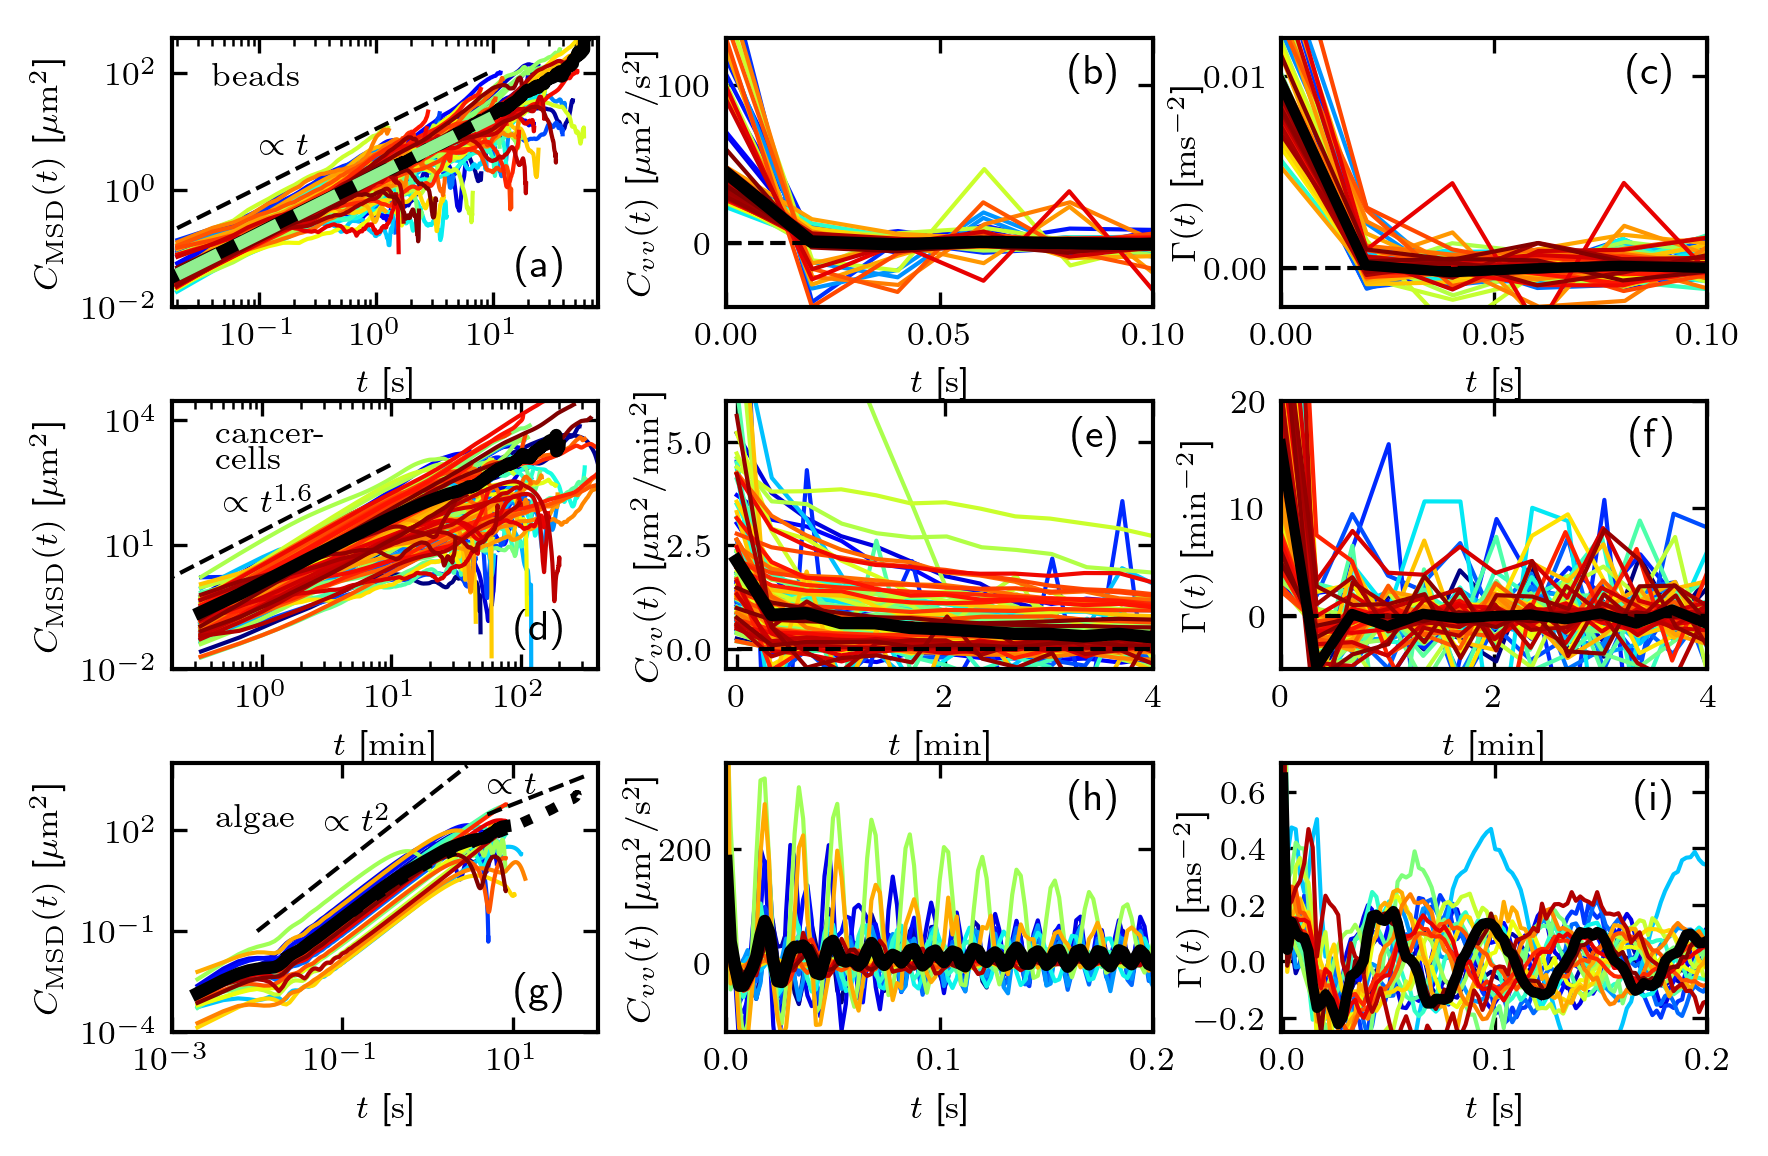

In [36]:
@mpltex.acs_decorator
def plot_msd_vacf_kern():
    fig, ax = plt.subplots(3, 3, dpi=300)

    plot_single_cell_axin(dict_1000nm['msd'], 1/50.41, ax[0, 0], msd=True, xlabel=r'$t$ [$\rm{s}$]', ylabel=r'$C_{\rm{MSD}} (t)$ [$\mu \rm{m}^2$]', xlim=[0.018, 80], ylim=[0.01, 400]) #[filt_inds, :]
    # 1.38e-23 * 300 / (6 * np.pi * 5e-7 * 1e-3) # = D = 0.439 mum^2 / s
    t = np.arange(0.02, 10, 0.1)
    ax[0, 0].plot(t, 4 * 0.439 * t, c='lightgreen', lw=3, ls='--')
    ax[0, 0].plot(t, 25 * 0.439 * t, c='k', ls='--')
    ax[0, 0].text(0.1, 4, '$\propto t$')

    plot_single_cell_axin(msdx_all20_cut[:-1, :], 1/3, ax[1, 0], msd=True, xlabel=r'$t$ [$\rm{min}$]', ylabel=r'$C_{\rm{MSD}} (t)$ [$\mu \rm{m}^2$]', xlim=[0.2, 400], ylim=[0.01, 30000], av_cut=600)
    ax[1, 0].plot(t, 3.1 * 7 * t**1.6, c='k', ls='--')
    ax[1, 0].text(0.5, 3.1 * 20, '$\propto t^{1.6}$')



    plot_single_cell_axin(msds, 0.002, ax[2, 0], msd=True, xlabel=r'$t$ [$\rm{s}$]', ylabel=r'$C_{\rm{MSD}} (t)$ [$\mu \rm{m}^2$]', xlim=[0.001, 100], ylim=[1e-4, 1e4], av_cut=4000)
    av_syn_msd_longt = np.load('./average_syn_longt_msd_dt002s.npy')
    ax[2, 0].plot((np.arange(len(av_syn_msd_longt))+1) * 0.02, av_syn_msd_longt, ls=':', c='k', lw=2.5)
    ax[2, 0].plot(np.arange(0.01,3,0.1), 1e3*np.arange(0.01,3,0.1)**2,ls='dashed',c='k')
    ax[2, 0].text(0.06, 100, '$\propto t^2$')

    tt = np.arange(5, 80)
    ax[2, 0].plot(tt, 60 * tt, c='k', ls='--')
    ax[2, 0].text(5, 1300, '$\propto t$')


    plot_single_cell_axin(0.5 * (dict_1000nm['cvvx'] + dict_1000nm['cvvy']), 1/50.41, ax[0, 1], xlabel=r'$t$ [$\rm{s}$]', ylabel=r'$C_{vv} (t)$ [$\mu \rm{m}^2/\rm{s}^2$]', xlim=[0, 0.1], ylim=[-40, 130], ylabelpad=-0.1)

    plot_single_cell_axin(vacf_all20_cut[:-1, :], 1/3, ax[1, 1], xlabel=r'$t$ [$\rm{min}$]', ylabel=r'$C_{vv} (t)$ [$\mu \rm{m}^2/\rm{min}^2$]', xlim=[-0.1, 4], ylim=[-0.5, 6], ylabelpad=-0.001)

    plot_single_cell_axin(0.5 * (vxacf_s + vyacf_s), 0.002, ax[2, 1], xlabel=r'$t$ [$\rm{s}$]', ylabel=r'$C_{vv} (t)$ [$\mu \rm{m}^2/\rm{s}^2$]', xlim=[0, 0.2], ylim=np.array([-120, 350]), ylabelpad=-0.1)


    plot_single_cell_axin(1e-6 * dict_1000nm['kernel_av'], 1/50.41, ax[0, 2], xlabel=r'$t$ [$\rm{s}$]', ylabel=r'$\Gamma (t)$ [$\rm{ms}^{-2}$]', xlim=[0, 0.1], ylim=1e-6 * np.array([-2000, 12000]), cmean='None', ylabelpad=-0.2)
    ax[0, 2].plot(np.arange(20) / 50.41,1e-6 *  mean_kern_1000nm[:20], c='k', lw=2.5)

    plot_single_cell_axin(kernel_all20_cut[:-1, :], 1/3, ax[1, 2], xlabel=r'$t$ [$\rm{min}$]', ylabel=r'$\Gamma (t)$ [$\rm{min}^{-2}$]', xlim=[0, 4], ylim=[-5, 20], cmean='None')
    ax[1, 2].plot(np.arange(20) / 3, mean_kern_all20_cut[:20], c='k', lw=2.5)

    plot_single_cell_axin(1e-6 * kernel_av_s, 0.002, ax[2, 2], xlabel=r'$t$ [$\rm{s}$]', ylabel=r'$\Gamma (t)$ [$\rm{ms}^{-2}$]', xlim=[-0.001, 0.2], ylim=[-0.25, 0.7], cmean='None', ylabelpad=-4)
    ax[2, 2].plot(np.arange(101) * 0.002, 1e-6 * mean_kern_s[:101], c='k', lw=2.5)

    ax[0, 2].set_yticks([0, 0.01])
    ax[2, 2].set_yticks([-0.2, 0, 0.2, 0.4, 0.6])

    ax[0, 0].text(0.04, 60, r'$\rm{beads}$')
    ax[1, 0].text(0.44, 5 * 600, r'$\rm{cancer}$-')
    ax[1, 0].text(0.44, 5 * 140, r'$\rm{cells}$')
    ax[2, 0].text(0.0033, 130, r'$\rm{algae}$')

    k = 0
    for i in range(3):
        for j in range(3):
            if j == 0:
                ax[i, j].text(0.93, 0.15, '(' + alphabet[k] + ')',
                    horizontalalignment='right',
                    verticalalignment='center',
                    rotation=0,
                    fontsize=10,
                    transform=ax[i, j].transAxes)
            else:
                ax[i, j].text(0.93, 0.87, '(' + alphabet[k] + ')',
                    horizontalalignment='right',
                    verticalalignment='center',
                    rotation=0,
                    fontsize=10,
                    transform=ax[i, j].transAxes)
            k += 1
    ax[0, 1].plot([0, 0.1], [0, 0], c='k', lw=1, ls='--')
    ax[0, 2].plot([0, 0.1], [0, 0], c='k', lw=1, ls='--')
    ax[1, 1].plot([0, 4], [0, 0], c='k', lw=1, ls='--')
    ax[1, 2].plot([0, 4], [0, 0], c='k', lw=1, ls='--')

    plt.subplots_adjust(wspace=0.3, hspace=0.35, right=1.7, top=1.6)

plot_msd_vacf_kern()
plt.show()

# Fig 4

0.9996628396027792
0.9643549907288346
0.9531703603455595


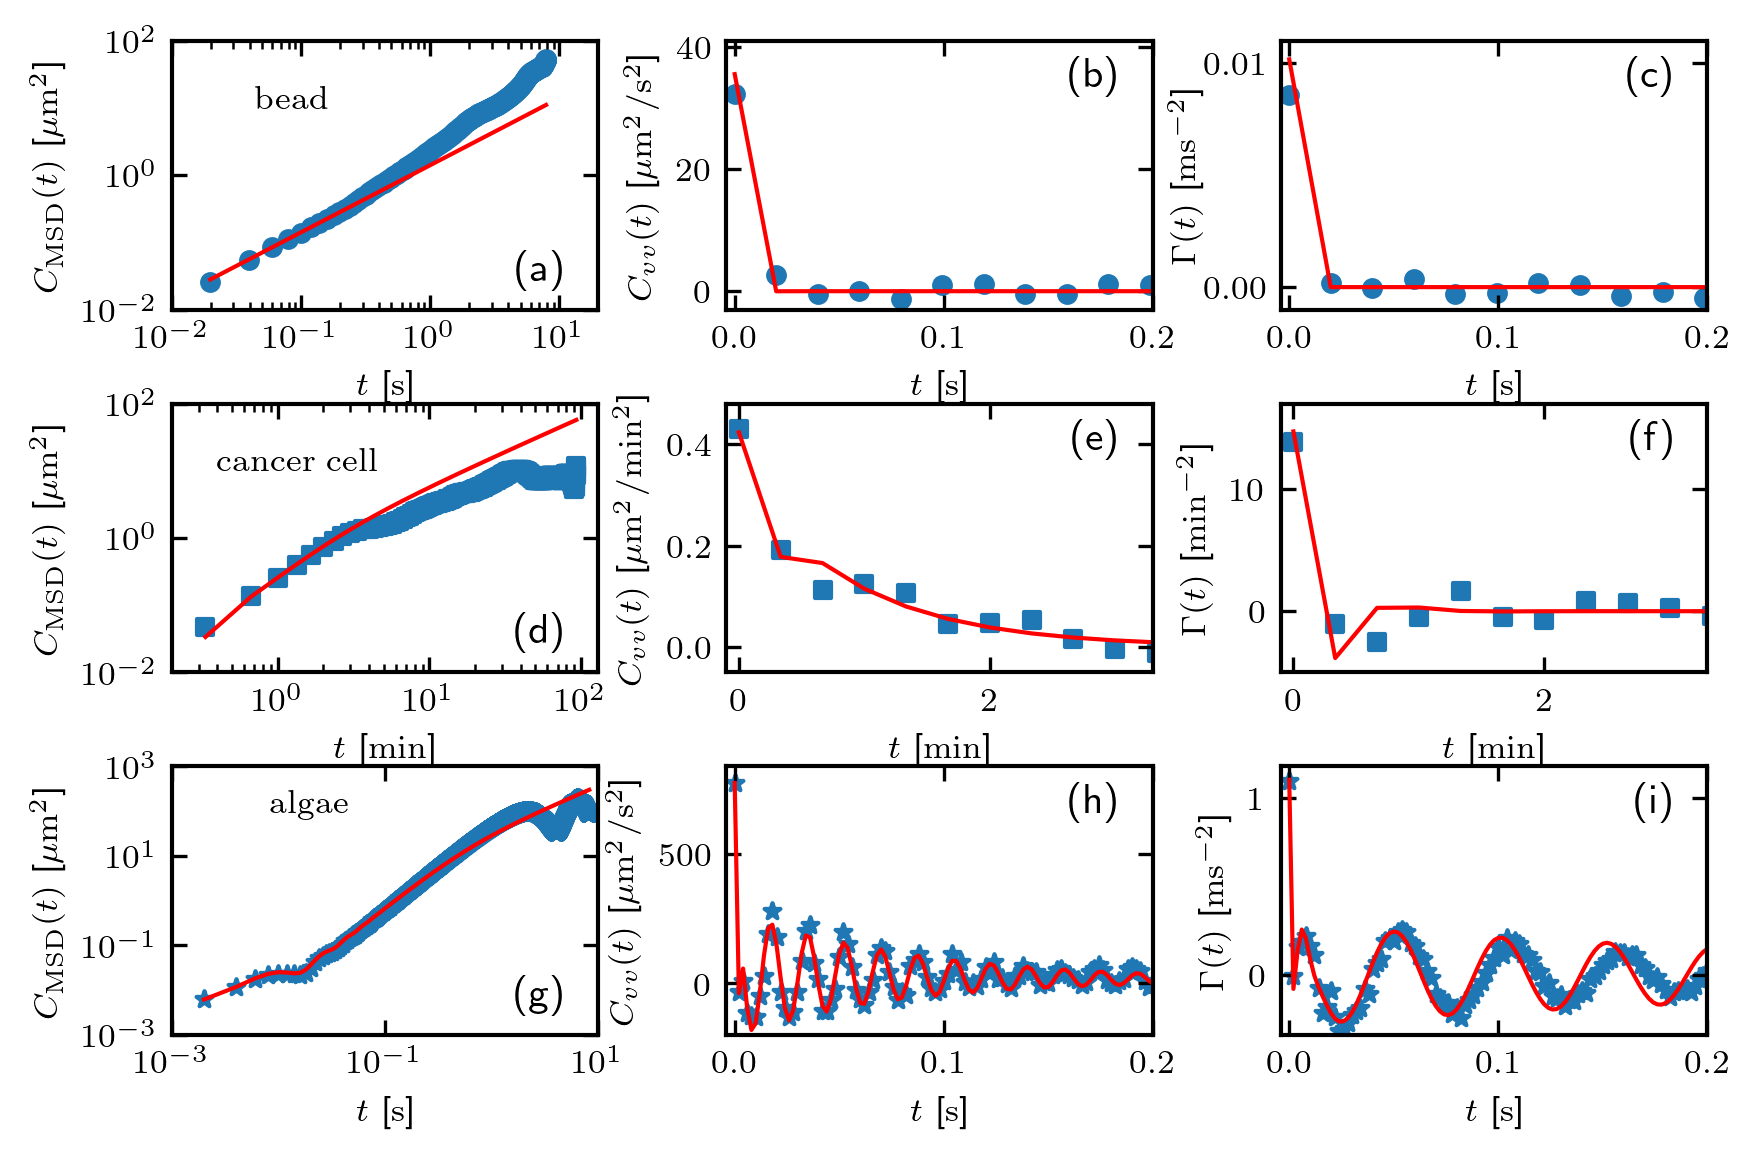

In [37]:
@mpltex.acs_decorator
def plot_msd_vacf_kern_fit():
    fig, ax = plt.subplots(3, 3, dpi=300)
    
    ind_ex = 105
    msd_example_beads = dict_1000nm['msd'][filt_inds_beads, :][inds_fd08, :][ind_ex, :].compressed()
    tb = np.arange(len(msd_example_beads)) / 50.41
    ax[0, 0].scatter(tb[1:], msd_example_beads[1:])
    ax[0, 0].plot(tb[1:], 2 * msd_diffusion_noise(*opt_beads_filt[ind_ex, :] , tb)[1:], c='r')
    ax[0, 0].loglog()
    ax[0, 0].set_xlabel(r'$t$ [$\rm{s}$]')
    ax[0, 0].set_ylabel(r'$C_{\rm{MSD}} (t)$ [$\mu \rm{m}^2$]')

    print(rsq_beads[ind_ex])

    vacf_example_beads = 0.5 * (dict_1000nm['cvvx'][filt_inds_beads, :][inds_fd08, :][ind_ex, :].compressed() + dict_1000nm['cvvy'][filt_inds_beads, :][inds_fd08, :][ind_ex, :].compressed())
    ax[0, 1].scatter(tb[:11], vacf_example_beads[:11])
    ax[0, 1].plot(tb[:11], vacf_noise_diffusion(*opt_beads_filt[ind_ex, :] , tb[:12], msd=msd_diffusion), c='r')
    ax[0, 1].set_ylim(-3, 41)
    ax[0, 1].set_xlim(-0.004, 0.2)
    ax[0, 1].set_xlabel(r'$t$ [$\rm{s}$]')
    ax[0, 1].set_ylabel(r'$C_{vv} (t)$ [$\mu \rm{m}^2/\rm{s}^2$]')

    kern_example_beads = dict_1000nm['kernel_av'][filt_inds_beads, :][inds_fd08, :][ind_ex, :].compressed()
    ax[0, 2].scatter(tb[:11], 1e-6 * kern_example_beads[:11])
    ax[0, 2].plot(tb[:11], 1e-6 * kernel_1dcc(vacf_noise_diffusion(*opt_beads_filt[ind_ex, :] , tb[:14], msd=msd_diffusion), 1/50.41), c='r')
    ax[0, 2].set_ylim(-1e-6 * 1000, 1e-6 * 11000)
    ax[0, 2].set_xlim(-0.004, 0.2)
    ax[0, 2].set_xlabel(r'$t$ [$\rm{s}$]')
    ax[0, 2].set_ylabel(r'$\Gamma (t)$ [$\rm{ms}^{-2}$]', labelpad=-0.22)


    ind_ex_opt = 1
    ind_ex = 66 # = indices_opt_cancer[ind_ex_opt]
    
    tb = np.arange(len(msdx_all20_cut[ind_ex, :].compressed())) / 3
    ax[1, 0].scatter(tb[1:], msdx_all20_cut[ind_ex, 1:].compressed(), marker='s')
    ax[1, 0].plot(tb[1:], msd_prw_noise(*opt_mb231[ind_ex_opt, :] , tb[1:]), c='r')
    ax[1, 0].loglog()
    ax[1, 0].set_xlabel(r'$t$ [$\rm{min}$]')
    ax[1, 0].set_ylabel(r'$C_{\rm{MSD}} (t)$ [$\mu \rm{m}^2$]')

    ax[1, 1].scatter(tb[:11], vacf_all20_cut[ind_ex, :11], marker='s')
    ax[1, 1].plot(tb[:11], vacf_noise_prw(*opt_mb231[ind_ex_opt, :] , tb[:12], msd=msd_prw), c='r')

    ax[1, 1].set_xlabel(r'$t$ [$\rm{min}$]')
    ax[1, 1].set_ylabel(r'$C_{vv} (t)$ [$\mu \rm{m}^2/\rm{min}^2$]')

    print(rsq_mb231[ind_ex_opt])
    
    ax[1, 2].scatter(tb[:11], kernel_all20_cut[ind_ex, :11], marker='s')
    ax[1, 2].plot(tb[:11], kernel_1dcc(vacf_noise_prw(*opt_mb231[ind_ex_opt, :] , tb[:14], msd=msd_prw), 1/3), c='r')

    ax[1, 2].set_xlabel(r'$t$ [$\rm{min}$]')
    ax[1, 2].set_ylabel(r'$\Gamma (t)$ [$\rm{min}^{-2}$]')
    

    ind_ex_opt = 3
    ind_ex = indices_opt_syn[ind_ex_opt] - 1
    
    tb = np.arange(len(msds[ind_ex, :].compressed())) / 500
    ax[2, 0].scatter(tb[1:], msds[ind_ex, 1:].compressed(), marker='*')
    ax[2, 0].plot(tb[1:], 2 * msd_noise_osc(*opt_syn[ind_ex_opt, :] , tb, msd=msd_osc_sincos)[1:], c='r')
    ax[2, 0].loglog()
    ax[2, 0].set_xlabel(r'$t$ [$\rm{s}$]')
    ax[2, 0].set_ylabel(r'$C_{\rm{MSD}} (t)$ [$\mu \rm{m}^2$]')

    vacf_ex = 0.5 * (vxacf_s[ind_ex, :].compressed() + vyacf_s[ind_ex, :].compressed())
    ax[2, 1].scatter(tb[:101], vacf_ex[:101], marker='*')
    ax[2, 1].plot(tb[:101], vacf_noise_osc(*opt_syn[ind_ex_opt, :] , tb[:102], msd=msd_osc_sincos), c='r')
    ax[2, 1].set_ylim(-200, 840)
    ax[2, 1].set_xlim(-0.004, 0.2)
    ax[2, 1].set_xlabel(r'$t$ [$\rm{s}$]')
    ax[2, 1].set_ylabel(r'$C_{vv} (t)$ [$\mu \rm{m}^2/\rm{s}^2$]')

    print(rsq_syn[ind_ex_opt])
    
    ax[2, 2].scatter(tb[:101], 1e-6 * kernel_av_s[ind_ex, :101], marker='*')
    ax[2, 2].plot(tb[:101], 1e-6 * kernel_1dcc(vacf_noise_osc(*opt_syn[ind_ex_opt, :] , tb[:104], msd=msd_osc_sincos), 0.002), c='r')
    ax[2, 2].set_ylim(-0.34, 1.18)
    ax[2, 2].set_xlim(-0.004, 0.2)
    ax[2, 2].set_xlabel(r'$t$ [$\rm{s}$]')
    ax[2, 2].set_ylabel(r'$\Gamma (t)$ [$\rm{ms}^{-2}$]')

    ax[0, 0].set_yticks([0.01, 1, 100])
    ax[0, 2].set_yticks([0, 0.01])

    ax[1, 0].set_xticks([1, 10, 100])
    ax[2, 0].set_yticks([0.001, 0.1, 10, 1000])


    ax[0, 0].set_xlim(0.01, 20)
    ax[1, 0].set_xlim(0.2, 130)
    ax[2, 0].set_xlim(1e-3, 10)

    ax[1, 1].set_xlim(-0.1, 3.3)
    ax[1, 1].set_ylim(-0.05, 0.48)
    ax[1, 2].set_xlim(-0.1, 3.3)
    ax[1, 2].set_ylim(-5, 17)

    ax[0, 0].text(0.044, 10, r'$\rm{bead}$')
    ax[1, 0].text(0.4, 10, r'$\rm{cancer}$ $\rm{cell}$')
    ax[2, 0].text(0.0083, 90, r'$\rm{algae}$')

    k = 0
    for i in range(3):
        for j in range(3):
            if j == 0:
                ax[i, j].text(0.93, 0.15, '(' + alphabet[k] + ')',
                    horizontalalignment='right',
                    verticalalignment='center',
                    rotation=0,
                    fontsize=10,
                    transform=ax[i, j].transAxes)
            else:
                ax[i, j].text(0.93, 0.87, '(' + alphabet[k] + ')',
                    horizontalalignment='right',
                    verticalalignment='center',
                    rotation=0,
                    fontsize=10,
                    transform=ax[i, j].transAxes)
            k += 1
    
    plt.subplots_adjust(wspace=0.3, hspace=0.35, right=1.7, top=1.6)


plot_msd_vacf_kern_fit()
plt.show()

# Fig 5 Parameter Distributions

131 135
23 23


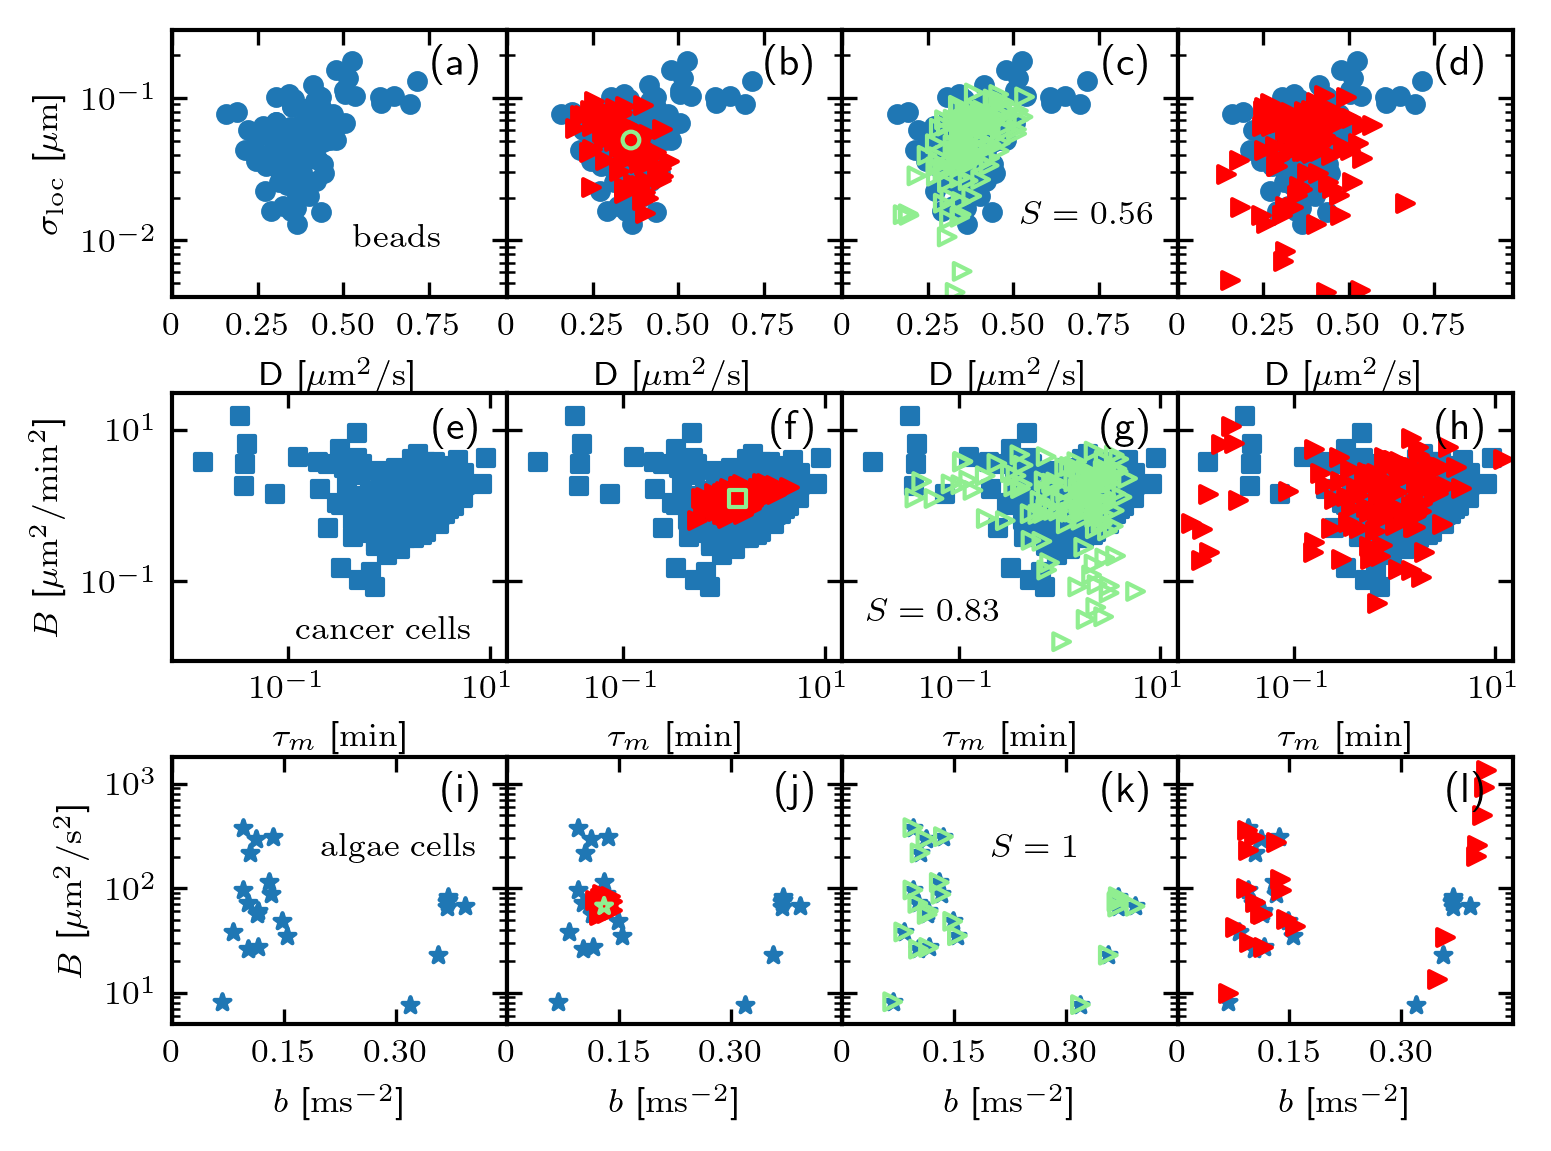

In [38]:
@mpltex.acs_decorator
def plot_distris():
    fig, ax = plt.subplots(3, 4, dpi=300)

    filt_ind = filt_distr(opt_beads_filt, 0.001, 0.2)
    ax[0, 0].scatter(opt_beads_filt[filt_ind, 0], opt_beads_filt[filt_ind, 1])
    ax[0, 0].set_ylabel(r'$\sigma_{\rm{loc}}$ [$\mu \rm{m}$]')

    filt_ind = filt_distr(opt_mb231, 0.01, 1)
    ax[1, 0].scatter(opt_mb231[filt_ind, 0], opt_mb231[filt_ind, 1], marker='s')
    ax[1, 0].set_ylabel(r'$B$ [$\mu \rm{m}^2/\rm{min}^2$]')

    filt_ind = filt_distr(opt_syn, 0, 0.05)
    ax[2, 0].scatter(1e-6 * opt_syn[filt_ind, 1], opt_syn[filt_ind, -2], marker='*')
    ax[2, 0].set_ylabel(r'$B$ [$\mu \rm{m}^2/\rm{s}^2$]')



    filt_ind_beads = filt_distr(opt_beads_filt, 0.001, 0.2)
    ax[0, 1].scatter(opt_beads_filt[filt_ind_beads, 0], opt_beads_filt[filt_ind_beads, 1])

    mean_beads_distr = np.load('./test_method/beads_corrected_fD08_msd95_med_idx10_var0percent_av100.npy')
    filt_ind = filt_distr(mean_beads_distr, 0.001, 0.2)
    
    ax[0, 1].scatter(mean_beads_distr[filt_ind, 0], mean_beads_distr[filt_ind, 1], marker='>', c='r')
    ax[0, 1].scatter(np.median(opt_beads_filt[filt_ind_beads, 0]), np.median(opt_beads_filt[filt_ind_beads, 1]), facecolor='None', edgecolor='lightgreen')


    filt_ind = filt_distr(opt_mb231, 0.01, 1)
    print(len(filt_ind), len(opt_mb231[:, 0]))
    ax[1, 1].scatter(opt_mb231[filt_ind, 0], opt_mb231[filt_ind, 1], marker='s')


    omb231_sim0 = np.load('./mb231_optimize/indi2_med_idx10_var0percent.npy')
    cond_err = filt_distr(omb231_sim0, 0.01, 1)
    omb231_sim0 = omb231_sim0[cond_err, :]

    ax[1, 1].scatter(omb231_sim0[:, 0], omb231_sim0[:, 1], marker='>', label=r'median simulation', c='r')
    ax[1, 1].scatter(np.median(omb231_sim0[:, 0]), np.median(omb231_sim0[:, 1]), marker='s', facecolor='None', edgecolor='lightgreen')


    filt_ind_syn = filt_distr(opt_syn, 0, 0.05)
    print(len(filt_ind_syn), len(opt_syn[:, 0]))
    ax[2, 1].scatter(1e-6 * opt_syn[filt_ind_syn, 1], opt_syn[filt_ind_syn, -2], marker='*')

    med_syn_distr = np.load('./chlamy_optimize/locfitsyn_sc_99_med_idx100_var0percent_av100.npy')
    filt_ind = filt_distr(med_syn_distr, 0, 0.05)

    ax[2, 1].scatter(1e-6 * med_syn_distr[filt_ind, 1], med_syn_distr[filt_ind, -2], marker='>', c='r')
    ax[2, 1].scatter(1e-6 * np.median(opt_syn[filt_ind_syn, 1]), np.median(opt_syn[filt_ind_syn, -2]), marker='*', facecolor='None', edgecolor='lightgreen')



    filt_ind = filt_distr(opt_beads_filt, 0.001, 0.2)
    ax[0, 3].scatter(opt_beads_filt[filt_ind, 0], opt_beads_filt[filt_ind, 1])

    mean_beads_distr = np.load('./test_method/beads_corrected_fD08_msd1_med_idx10_var56percent_av100.npy')
    filt_ind = filt_distr(mean_beads_distr, 0.001, 0.2)
    ax[0, 3].scatter(mean_beads_distr[filt_ind, 0], mean_beads_distr[filt_ind, 1], marker='>', c='r')


    filt_ind = filt_distr(opt_mb231, 0.01, 1)
    ax[1, 3].scatter(opt_mb231[filt_ind, 0], opt_mb231[filt_ind, 1], marker='s')


    omb231_sim0 = np.load('./mb231_optimize/indi0_med_idx10_var80percent.npy')
    cond_err = filt_distr(omb231_sim0, 0.01, 1)
    omb231_sim0 = omb231_sim0[cond_err, :]

    ax[1, 3].scatter(omb231_sim0[:, 0], omb231_sim0[:, 1], marker='>', label=r'median simulation', c='r')


    filt_ind = filt_distr(opt_syn, 0.0001, 0.05)
    ax[2, 3].scatter(1e-6 * opt_syn[filt_ind, 1], opt_syn[filt_ind, -2], marker='*')


    syn_100per_distr_sim = np.load('./chlamy_optimize/locfitsyn_sc_0_med_idx100_varfull_av1000.npy')
    filt_ind = filt_distr(syn_100per_distr_sim, 0, 0.05)
    ax[2, 3].scatter(1e-6 * syn_100per_distr_sim[filt_ind, 1], syn_100per_distr_sim[filt_ind, -2], marker='>', c='r')
    



    filt_ind = filt_distr(opt_beads_filt, 0.001, 0.2)
    ax[0, 2].scatter(opt_beads_filt[filt_ind, 0], opt_beads_filt[filt_ind, 1])

    mean_beads_distr = np.load('./test_method/beads_corrected_fD08_msdorigdistr1_med_idx10_var56percent_av100.npy')
    filt_ind = filt_distr(mean_beads_distr, 0.001, 0.2)
    ax[0, 2].scatter(mean_beads_distr[filt_ind, 0], mean_beads_distr[filt_ind, 1], marker='>', facecolor='None', edgecolor='lightgreen')


    filt_ind = filt_distr(opt_mb231, 0.01, 1)
    ax[1, 2].scatter(opt_mb231[filt_ind, 0], opt_mb231[filt_ind, 1], marker='s')


    omb231_sim0 = np.load('./mb231_optimize/indiorigdistr0_med_idx10_var80percent_av100.npy')
    cond_err = filt_distr(omb231_sim0, 0.01, 1)
    omb231_sim0 = omb231_sim0[cond_err, :]

    ax[1, 2].scatter(omb231_sim0[:, 0], omb231_sim0[:, 1], marker='>', label=r'median simulation', facecolor='None', edgecolor='lightgreen')

    filt_ind = filt_distr(opt_syn, 0, 0.05)
    ax[2, 2].scatter(1e-6 * opt_syn[filt_ind, 1], opt_syn[filt_ind, -2], marker='*')

    ax[2, 2].scatter(1e-6 * opt_syn[filt_ind, 1], opt_syn[filt_ind, -2], marker='>', facecolor='None', edgecolor='lightgreen')


    ax[0, 0].set_xlim(0.1, 1)
    ax[0, 0].set_ylim(0.002, 0.3)
    k = 0
    for i in range(3):
        for j in range(4):
            if i == 0:
                ax[i, j].set_xlabel(r'D [$\mu \rm{m}^2/\rm{s}$]')
                ax[i, j].set_xlim(0, 0.98)
                ax[i, j].set_ylim(0.004, 0.3)
                ax[i, j].set_xticks([0, 0.25, 0.5, 0.75])
                ax[i, j].set_xticklabels([r'$0$', r'$0.25$', r'$0.50$', r'$0.75$'])
                ax[i, j].semilogy()
                
            elif i == 1:
                ax[i, j].set_xlabel(r'$\tau_m$ [$\rm{min}$]')
                ax[i, j].set_xlim(0.007, 15)
                ax[i, j].set_ylim(0.009, 30)
                ax[i, j].set_xticks([0.1, 1, 10])
                ax[i, j].loglog()

            elif i == 2:
                ax[i, j].set_xlabel(r'$b$ [$\rm{ms}^{-2}$]')
                ax[i, j].set_xticks([0, 0.15, 0.3])
                ax[i, j].set_xticklabels([r'$0$', r'$0.15$', r'$0.30$'])
                ax[i, j].set_xlim(0, 0.45)
                ax[i, j].set_ylim(5, 1800)
                ax[i, j].semilogy()


            if j > 0:
                ax[i, j].set_yticklabels([])

            ax[i, j].text(0.93, 0.87, '(' + alphabet[k] + ')',
                horizontalalignment='right',
                verticalalignment='center',
                rotation=0,
                fontsize=10,
                transform=ax[i, j].transAxes)
            
            k += 1


    ax[0, 0].text(0.53, 0.009, r'$\rm{beads}$')
    ax[1, 0].text(0.12, 0.0174, r'$\rm{cancer}$ $\rm{cells}$')
    ax[2, 0].text(0.2, 200, r'$\rm{algae}$ $\rm{cells}$')

    ax[0, 2].text(0.52, 0.013, r'$S=0.56$')
    ax[1, 2].text(0.012, 0.03, r'$S=0.83$')
    ax[2, 2].text(0.2, 200, r'$S=1$')

    plt.subplots_adjust(wspace=0, hspace=0.36, right=1.5, top=1.6)


plot_distris()
plt.show()

# Fig 6 barplot

In [39]:
load_pvals('./mb231_optimize', 'indi_cov', test='', mean_str='_med')

load_pvals('./test_method', 'beads_corrected_fD08_msd', test='') #is 2d, but not in name

load_pvals('./chlamy_optimize/', 'locfitsyn_sc_2d', mean_str='_med', test='', idx=100, n_real=100, alpha=0.05)

indi_covpvals_med_idx10_var0percent_nreal100 : 1.0
indi_covpvals_med_idx10_var10percent_nreal100 : 1.0
indi_covpvals_med_idx10_var20percent_nreal100 : 0.97
indi_covpvals_med_idx10_var30percent_nreal100 : 0.69
indi_covpvals_med_idx10_var40percent_nreal100 : 0.46
indi_covpvals_med_idx10_var50percent_nreal100 : 0.23
indi_covpvals_med_idx10_var60percent_nreal100 : 0.09
indi_covpvals_med_idx10_var64percent_nreal100 : 0.06
indi_covpvals_med_idx10_var66percent_nreal100 : 0.03
indi_covpvals_med_idx10_var70percent_nreal100 : 0.02
indi_covpvals_med_idx10_var80percent_nreal100 : 0.01
indi_covpvals_med_idx10_var90percent_nreal100 : 0.0
indi_covpvals_med_idx10_varfull_nreal100 : 0.0
beads_corrected_fD08_msdpvals_med_idx10_var0percent_nreal100 : 0.99
beads_corrected_fD08_msdpvals_med_idx10_var10percent_nreal100 : 0.81
beads_corrected_fD08_msdpvals_med_idx10_var20percent_nreal100 : 0.36
beads_corrected_fD08_msdpvals_med_idx10_var30percent_nreal100 : 0.1
beads_corrected_fD08_msdpvals_med_idx10_var31pe

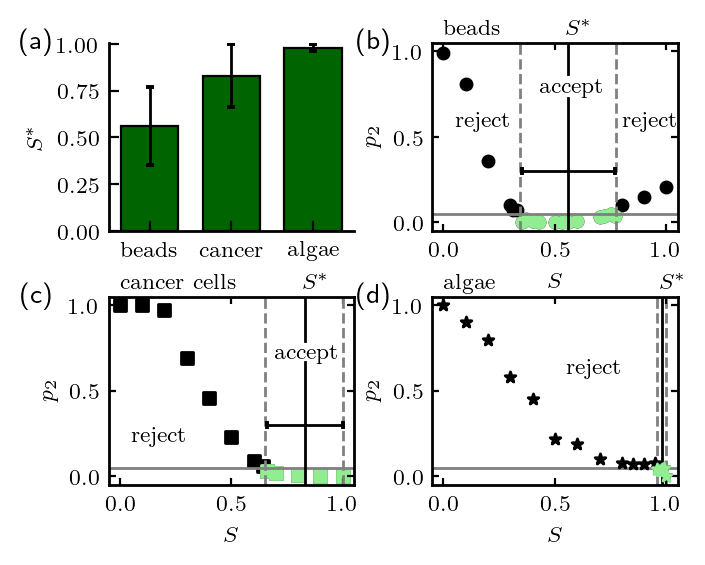

In [40]:
@mpltex.acs_decorator
def plot_bar_pvals():    
    fig, ax = plt.subplots(2, 2, dpi=200)
    x = [1, 2, 3]  # x positions of the bars
    height1 = np.array([0.56, 0.83, 0.98])  # heights of the lower part of the bars
    height2 = np.ones(len(height1)) - height1  # heights of the upper part of the bars

    ax[0, 0].bar(x, height1, width=0.7, color='darkgreen', edgecolor='black', linewidth=0.8)

    ax[0, 0].errorbar(x, height1, yerr=[0.21, 0.17, 0.02], fmt='none', ecolor='k', capsize=1.5, capthick=1.4)

    ax[0, 0].set_ylabel(r'$S^*$')
    ax[0, 0].set_xticks(x)
    ax[0, 0].set_xticklabels([r'$\rm{beads}$', r'$\rm{cancer}$', r'$\rm{algae}$'])
    ax[0, 0].set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax[0, 0].set_ylim(0, 1.005)
    ax[0, 0].set_xlim(0.5, 3.5)

    ax[0, 0].spines['right'].set_visible(False)  # hide right edge
    ax[0, 0].spines['top'].set_visible(False)  # hide top edge
    ax[0, 0].tick_params(right=False, top=False) #hide ticks right and top

    ax[0, 1].scatter(percent_beads, pvals_beads, marker='o', c='k')
    ax[0, 1].scatter(percent_beads[np.where(pvals_beads <= 0.05)], pvals_beads[np.where(pvals_beads <= 0.05)], marker='o', c='lightgreen')
    ax[0, 1].plot([-0.05, 1.05], [0.05, 0.05], c='gray', alpha=1)
    ax[0, 1].plot([0.775, 0.775], [-0.05, 1.05], c='gray', alpha=1, ls='--')
    ax[0, 1].plot([0.345, 0.345], [-0.05, 1.05], c='gray', alpha=1, ls='--')
    ax[0, 1].plot([0.56, 0.56], [-0.05, 0.73], c='k')
    ax[0, 1].plot([0.56, 0.56], [0.87, 1.05], c='k')
    ax[0, 1].errorbar(0.56, 0.3, xerr=0.21, marker='None', capthick=1.4, capsize=1.5, ecolor='k')

    ax[0, 1].set_ylim(-0.05, 1.05)
    ax[0, 1].set_xlim(-0.05, 1.05)
    ax[0, 1].set_xlabel(r'$S$')
    ax[0, 1].set_ylabel(r'$p_2$')
    ax[0, 1].set_xticks([0, 0.5, 1])
    ax[0, 1].text(0.43, 0.76, r'$\rm{accept}$')
    ax[0, 1].text(0.05, 0.56, r'$\rm{reject}$')
    ax[0, 1].text(0.8, 0.56, r'$\rm{reject}$')
    ax[0, 1].text(0.55, 1.1, r'$S^*$')

    ax[1, 0].scatter(percent_mb231, pvals_mb231, marker='s', c='k')
    ax[1, 0].scatter(percent_mb231[np.where(pvals_mb231 <= 0.05)], pvals_mb231[np.where(pvals_mb231 <= 0.05)], marker='s', c='lightgreen')
    ax[1, 0].plot([-0.05, 1.05], [0.05, 0.05], c='gray', alpha=1)
    ax[1, 0].plot([0.65, 0.65], [-0.05, 1.05], c='gray', alpha=1, ls='--')
    ax[1, 0].plot([1, 1], [-0.05, 1.05], c='gray', alpha=1, ls='--')
    ax[1, 0].plot([0.83, 0.83], [-0.05, 0.67], c='k')
    ax[1, 0].plot([0.83, 0.83], [0.79, 1.05], c='k')
    ax[1, 0].errorbar(0.83, 0.3, xerr=0.17, marker='None', capthick=1.4, capsize=1.5, ecolor='k')

    ax[1, 0].set_ylim(-0.05, 1.05)
    ax[1, 0].set_xlim(-0.05, 1.05)
    ax[1, 0].set_xlabel(r'$S$')
    ax[1, 0].set_ylabel(r'$p_2$')
    ax[1, 0].set_xticks([0, 0.5, 1])
    ax[1, 0].text(0.69, 0.69, r'$\rm{accept}$')
    ax[1, 0].text(0.05, 0.2, r'$\rm{reject}$')
    ax[1, 0].text(0.82, 1.1, r'$S^*$')


    ax[1, 1].plot([-0.05, 1.05], [0.05, 0.05], c='gray', alpha=1, zorder=1)
    ax[1, 1].plot([1, 1], [-0.05, 1.05], c='gray', alpha=1, ls='--', zorder=1)
    ax[1, 1].plot([0.96, 0.96], [-0.05, 1.05], c='gray', alpha=1, ls='--', zorder=1)
    ax[1, 1].plot([0.98, 0.98], [-0.05, 1.05], c='k', zorder=1)

    ax[1, 1].scatter(percent_syn, pvals_syn, marker='*', c='k', zorder=2)
    ax[1, 1].scatter(percent_syn[np.where(pvals_syn <= 0.05)], pvals_syn[np.where(pvals_syn <= 0.05)], marker='*', c='lightgreen', zorder=2)
    
    ax[1, 1].text(0.55, 0.6, r'$\rm{reject}$')
    ax[1, 1].set_ylim(-0.05, 1.05)
    ax[1, 1].set_xlim(-0.05, 1.05)
    ax[1, 1].set_xlabel(r'$S$')
    ax[1, 1].set_ylabel(r'$p_2$')
    ax[1, 1].set_xticks([0, 0.5, 1])

    ax[1, 1].text(0.97, 1.1, r'$S^*$')



    ax[0, 0].text(-0.22, 1.01, '(' + alphabet[0] + ')',
                horizontalalignment='right',
                verticalalignment='center',
                rotation=0,
                fontsize=10,
                transform=ax[0, 0].transAxes)
    ax[0, 1].text(-0.16, 1.01, '(' + alphabet[1] + ')',
                horizontalalignment='right',
                verticalalignment='center',
                rotation=0,
                fontsize=10,
                transform=ax[0, 1].transAxes)
    ax[1, 0].text(-0.22, 1.01, '(' + alphabet[2] + ')',
                horizontalalignment='right',
                verticalalignment='center',
                rotation=0,
                fontsize=10,
                transform=ax[1, 0].transAxes)
    ax[1, 1].text(-0.16, 1.01, '(' + alphabet[3] + ')',
                horizontalalignment='right',
                verticalalignment='center',
                rotation=0,
                fontsize=10,
                transform=ax[1, 1].transAxes)
    
    ax[0, 1].text(0, 1.1, r'$\rm{beads}$')
    ax[1, 0].text(0, 1.1, r'$\rm{cancer}$ $\rm{cells}$')
    ax[1, 1].text(0, 1.1, r'$\rm{algae}$')

    ax[0, 1].tick_params(length=2.5)
    ax[1, 1].tick_params(length=2.5)
    ax[1, 0].tick_params(length=2.5)

    plt.subplots_adjust(wspace=0.32, right=1, top=1.1, hspace=0.35)


plot_bar_pvals()
plt.show()


# Median simulation (input all median means zero variance of input) PRW 500, 200, 100 steps

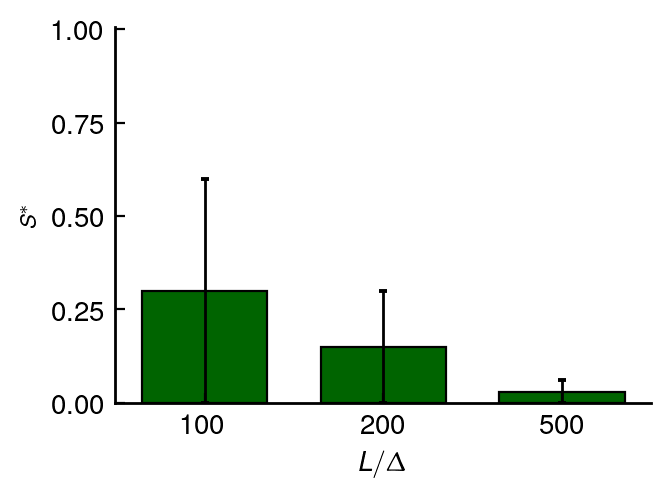

In [41]:
# load_pvals('./test_method', 'test_prw_0p')
# load_pvals('./test_method', 'test_prw_0p200_')
# load_pvals('./test_method', 'test_prw_0p_n100')
# opt_n500 = np.load('./test_method/opt_prw_sim_tm5_B20_err01_dt02_n500.npy')
# opt_n200 = np.load('./test_method/opt_prw_sim_tm5_B20_err01_dt02_n200.npy')
# opt_n100 = np.load('./test_method/opt_prw_sim_tm5_B20_err01_dt02_n100.npy')
@mpltex.acs_decorator
def plot_bar_medsim():    
    fig, ax = plt.subplots(1, 1, dpi=200)
    x = [1, 2, 3]  # x positions of the bars
    height1 = np.array([0.3, 0.15, 0.03])  # heights of the lower part of the bars

    ax.bar(x, height1, width=0.7, color='darkgreen', edgecolor='black', linewidth=0.8)
    ax.errorbar(x, height1, yerr=[0.3, 0.15, 0.03], fmt='none', ecolor='k', capsize=1.5, capthick=1.4)

    ax.set_ylabel(r'$S^*$')
    ax.set_xlabel(r'$L/\Delta$', fontsize=10)
    ax.set_xticks(x)
    ax.set_xticklabels([r'$100$', r'$200$', r'$500$'], fontsize=10)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_yticklabels([r'$0.00$', r'$0.25$', r'$0.50$', r'$0.75$', r'$1.00$'], fontsize=10)
    ax.set_ylim(0, 1.005)
    ax.set_xlim(0.5, 3.5)

    ax.spines['right'].set_visible(False)  # hide right edge
    ax.spines['top'].set_visible(False)  # hide top edge
    ax.tick_params(right=False, top=False) #hide ticks right and top
    plt.show()
plot_bar_medsim()

# Velocity distr aver non-Gauss

[-0.03545373  0.75693363]


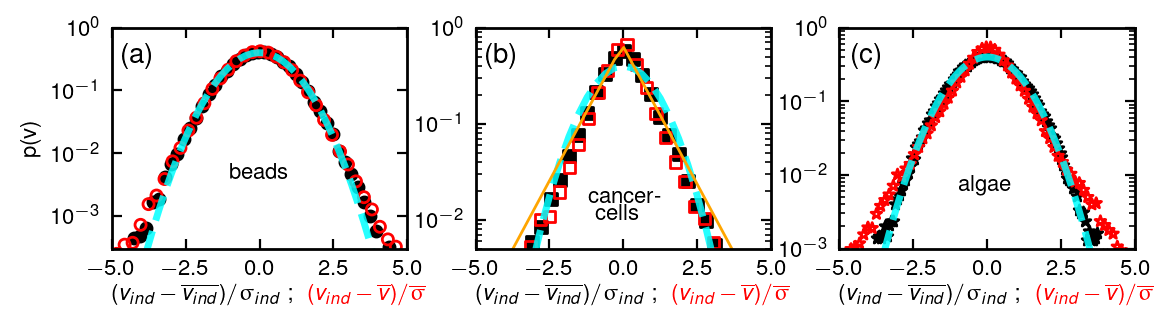

In [42]:
@mpltex.acs_decorator
def hist_vels_nongauss(bin_number=50):    
    fig, ax = plt.subplots(1, 3, dpi=200)

    vals_scale_all, bins_scale_all = np.histogram(np.append(vxscale_beads.compressed(), vyscale_beads.compressed()), bins=bin_number, density=True)
    mean_bins_scale_all = 0.5 * (bins_scale_all + np.roll(bins_scale_all, -1))[:-1]

    ax[0].scatter(mean_bins_scale_all, vals_scale_all, marker='o', c='k',label='average all cells')
    ax[0].plot(mean_bins_scale_all, np.exp(-mean_bins_scale_all**2/2)/np.sqrt(2*np.pi), c='cyan',lw=2.5, ls='dashed', alpha=0.85)

    vxy_beads_all = np.concatenate((dict_1000nm['vx'].compressed(), dict_1000nm['vy'].compressed()))
    vals_all_beads, bins_all_beads = np.histogram((vxy_beads_all-np.mean(vxy_beads_all))/np.std(vxy_beads_all), bins=bin_number, density=True)

    mean_bins_scale_after = (0.5*(bins_all_beads+np.roll(bins_all_beads,-1)))[:-1]
    ax[0].scatter(mean_bins_scale_after, vals_all_beads, marker='o', facecolors='none', edgecolors='red', label='$v_{all}-\overline{v_{all}}/\sigma(v_{all})$')

    vals_scale_all, bins_scale_all = np.histogram(v_scale_all20_cut.compressed(), bins=100, density=True)

    mean_bins_scale_all=(0.5*(bins_scale_all+np.roll(bins_scale_all,-1)))[:-1]
    ax[1].scatter(mean_bins_scale_all, vals_scale_all, marker='s', c='k',label='average all cells')
    ax[1].plot(mean_bins_scale_all, np.exp(-mean_bins_scale_all**2/2)/np.sqrt(2*np.pi), c='cyan',lw=2.5, ls='dashed', alpha=0.85)
    params, _ = curve_fit(laplace_distr, mean_bins_scale_all, vals_scale_all, p0=[0, 1])
    ax[1].plot(mean_bins_scale_all, laplace_distr(mean_bins_scale_all, *params), c='orange')
    print(params)


    vals_all_mb231, bins_all_mb231 = np.histogram((vall20_cut.compressed() - np.mean(vall20_cut.compressed())) / np.std(vall20_cut.compressed()), bins=100, density=True)
    mean_bins_scale_after = (0.5*(bins_all_mb231+np.roll(bins_all_mb231,-1)))[:-1]
    ax[1].scatter(mean_bins_scale_after, vals_all_mb231, marker='s', facecolors='none', edgecolors='red', label='$v_{all}-\overline{v_{all}}/\sigma(v_{all})$')



    vals_scale_all, bins_scale_all = np.histogram(np.concatenate((vscale_synx.compressed(), vscale_syny.compressed())), bins=200, density=True)
    mean_bins_scale_all = 0.5 * (bins_scale_all + np.roll(bins_scale_all, -1))[:-1]

    mean_bins_scale_all=(0.5*(bins_scale_all+np.roll(bins_scale_all,-1)))[:-1]
    ax[2].scatter(mean_bins_scale_all, vals_scale_all, marker='*', c='k',label='average all cells')
    ax[2].plot(mean_bins_scale_all, np.exp(-mean_bins_scale_all**2/2)/np.sqrt(2*np.pi), c='cyan',lw=2.5, ls='dashed', alpha=0.85)

    vxy_syn_all = np.concatenate((vxall_s.compressed(), vyall_s.compressed()))
    vals_all_s, bins_all_s = np.histogram((vxy_syn_all-np.mean(vxy_syn_all))/np.std(vxy_syn_all), bins=200, density=True)

    mean_bins_scale_after = (0.5*(bins_all_s+np.roll(bins_all_s,-1)))[:-1]
    ax[2].scatter(mean_bins_scale_after, vals_all_s, marker='*', facecolors='none', edgecolors='red', label='$v_{all}-\overline{v_{all}}/\sigma(v_{all})$')

    ax[0].set_xlim(-7, 7)
    ax[1].set_xlim(-5, 5)
    ax[2].set_xlim(-5, 5)
    ax[1].set_ylim(5e-3, 1)
    # ax[1].set_ylim(5e-5, 1)
    ax[2].set_ylim(1e-3, 1)
    ax[0].set_ylim(3e-4, 1)
    ax[0].set_xlim(-5, 5)

    

    ax[0].set_ylabel(r'p(v)')
    for i in range(3):
        ax[i].semilogy()

        xbox1 = TextArea("$(v_{ind}-\overline{v_{ind}})/\sigma_{ind}$ ; ", textprops=dict(color="k"))
        xbox3 = TextArea("$(v_{ind}-\overline{v})/\overline{\sigma}$", textprops=dict(color="red"))

        xbox = HPacker(children=[xbox1, xbox3],
                        align="center", pad=0, sep=5)

        anchored_xbox = AnchoredOffsetbox(loc=3, child=xbox, pad=0., frameon=False,
                                            bbox_to_anchor=(0, -0.26),
                                            bbox_transform=ax[i].transAxes, borderpad=0.)
        ax[i].add_artist(anchored_xbox)
        
    ax[0].set_yticks([1e-3, 1e-2, 1e-1, 1])
    ax[0].text(-1, 0.004, r'$\rm{beads}$')
    ax[1].text(-1.2, 0.015, r'$\rm{cancer}$-')
    ax[1].text(-0.96, 0.01, r'$\rm{cells}$')
    ax[2].text(-1, 0.006, r'$\rm{algae}$')

    plt.subplots_adjust(wspace=0.23, right=1.7, top=0.6)
    for i in range(3):
        ax[i].text(0.15, 0.87, '(' + alphabet[i] + ')',
                    horizontalalignment='right',
                    verticalalignment='center',
                    rotation=0,
                    fontsize=10,
                    transform=ax[i].transAxes)

    plt.show()

hist_vels_nongauss(bin_number=50)

# Least-square fit of noisy data

In [43]:
def exp_plus_const(x, a, b, c):
    return a * np.exp(-b * x) + c

def exp_osc(x, a, b, c):
    return a * np.exp(-b * x) * np.cos(c * x)

def add_noise(x, noise_level):
    return x + np.random.normal(0, noise_level, len(x))

def sigma(args, fun, trj, t):
    return trj - fun(t, *args)

# Define the true parameter values
# true_params = [10, 5, 8]
true_params = [20, 20, 8]

t = np.linspace(0, 100, 1000)

# create sample curves
# ntrj = 100000
# results = np.zeros((len(true_params), ntrj))
# for i in range(ntrj):
#     x0 = np.array([np.random.rand() * (100-0.01) + 0.01, np.random.rand() * (75-0.01) + 0.01, np.random.rand() * (100-0.01) + 0.01])
#     trj = add_noise(exp_plus_const(t, *true_params), 5)#(20) * np.exp(-t/(20)) + np.random.normal(0, 8, len(t))
#     res = least_squares(lambda x: sigma(x, exp_plus_const, trj, t), x0, bounds=([0.01, 0.01, 0.01], [150, 75, 150]))
#     results[:, i] = res.x

In [44]:
# np.save('fitres_exp_noise5_params20208_bounds15075150.npy', results)
results = np.load('fitres_exp_noise5_params20208_bounds15075150.npy')

19.984848537939616 20.00301665791823
34.18322617995549 19.981992970132865
7.996864867987737 7.997151296807655


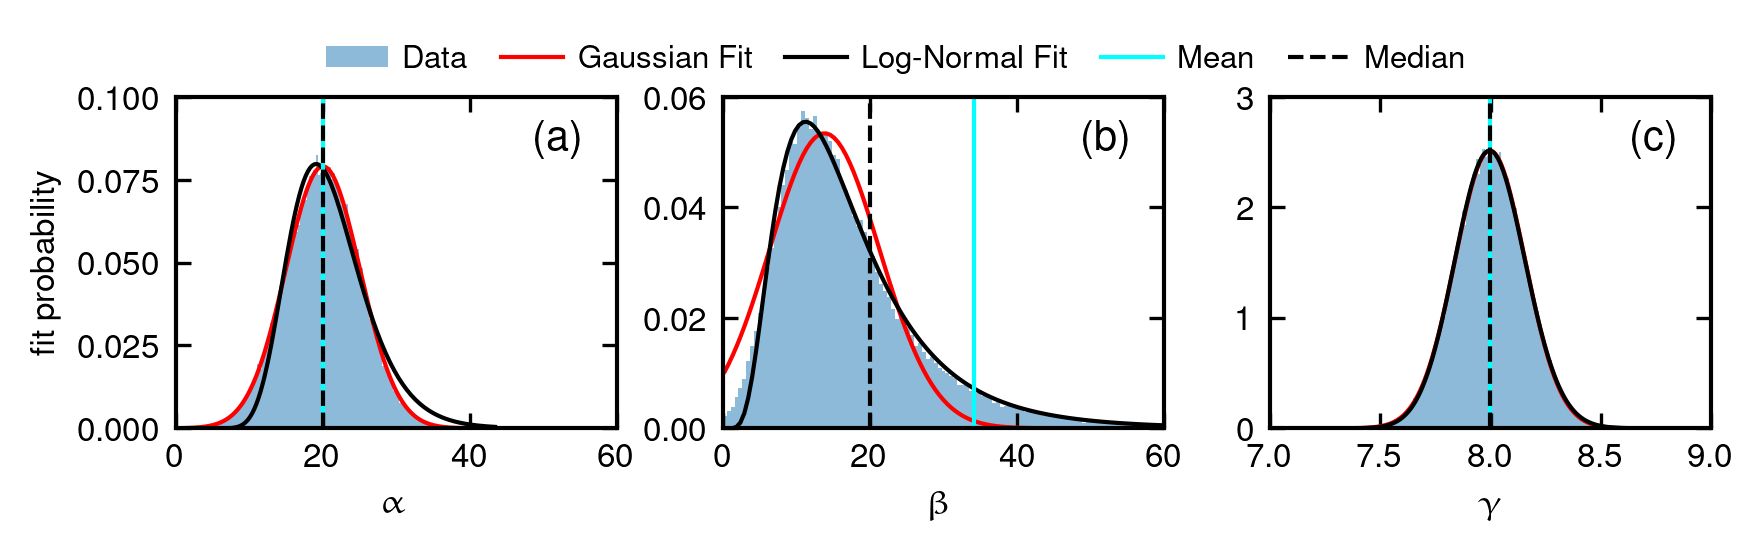

In [45]:
@mpltex.acs_decorator
def plot_hist_lsq():
    fig, ax = plt.subplots(1, 3, dpi=300)
    labels = [r'$\alpha$', r'$\beta$', r'$\gamma$']
    max_vals = [150, 75, 150]
    for i in range(len(results[:, 0])):
        data = results[i, :]
        hist, bins = np.histogram(data, bins='auto', density=True)
        if i == 1:
            hist, bins = np.histogram(data, range=(0, 60), bins='auto', density=True)

        bin_centers = (bins[:-1] + bins[1:]) / 2

        # Fit the Gaussian distribution
        popt_gauss, _ = curve_fit(Gauss, bin_centers, hist)

        # Fit the log-normal distribution
        popt_lognorm, _ = curve_fit(log_normal, bin_centers, hist)

        if i == 1:
            ax[i].hist(data, range=(0, 60), bins='auto', density=True, alpha=0.5, label='Data')
        else:
            ax[i].hist(data, bins='auto', density=True, alpha=0.5, label='Data')
        ax[i].plot(bin_centers, Gauss(bin_centers, *popt_gauss), 'r-', label='Gaussian Fit')
        ax[i].plot(bin_centers, log_normal(bin_centers, *popt_lognorm), 'k-', label='Log-Normal Fit')
        ax[i].set_xlabel(labels[i])
        ax[0].set_ylabel(r'fit probability')
        
        mean = np.mean(data[np.where(data < max_vals[i])[0]])
        ax[i].axvline(mean, color='cyan', ls='-', label='Mean')

        median = np.median(data)
        ax[i].axvline(median, color='k', ls='--', label='Median')
        print(mean, median)

    ax[0].legend(loc='upper right', bbox_to_anchor=(3, 1.25), ncol=5)

    # ax[0].text(0.73, 0.5, r'$\alpha e^{-\beta t} + \gamma$', fontsize=10, ha='center', va='center', transform=ax[0].transAxes)
    ax[1].set_xlim(0, 60)
    ax[2].set_xlim(7, 9)

    k = 0
    for j in range(3):
        ax[j].text(0.93, 0.87, '(' + alphabet[k] + ')',
            horizontalalignment='right',
            verticalalignment='center',
            rotation=0,
            fontsize=10,
            transform=ax[j].transAxes)
        k += 1
    
    plt.subplots_adjust(wspace=0.24, right=1.7, top=0.6)
    plt.show()
plot_hist_lsq()

# Fig test sim (simulate distribution)

In [46]:

simulated_distr2_10per = np.load('./test_method/distr20_med_idx10_var10percent_av100.npy')

gauss_10per_sim_input = np.load('./test_method/distr2origdistr0_med_idx10_var10percent_av100.npy')

distr_orig2 = np.load('./original_spread2_n100_dt1_10percent_cov_pretend.npy')
distr_exp_raw_2 = np.load('./pretend_experimental_data2_n100_dt1_10percent_cov_pretend.npy')
filt_err_inds = filt_distr(distr_exp_raw_2, 0.01, 2)
distr_exp2 = distr_exp_raw_2[filt_err_inds, :]


distr_sim_med = np.load('./test_method/0var_real' + str(int(0)) + 'distr.npy')
distr_sim_01var = np.load('./test_method/01var_real' + str(int(0)) + 'distr.npy')

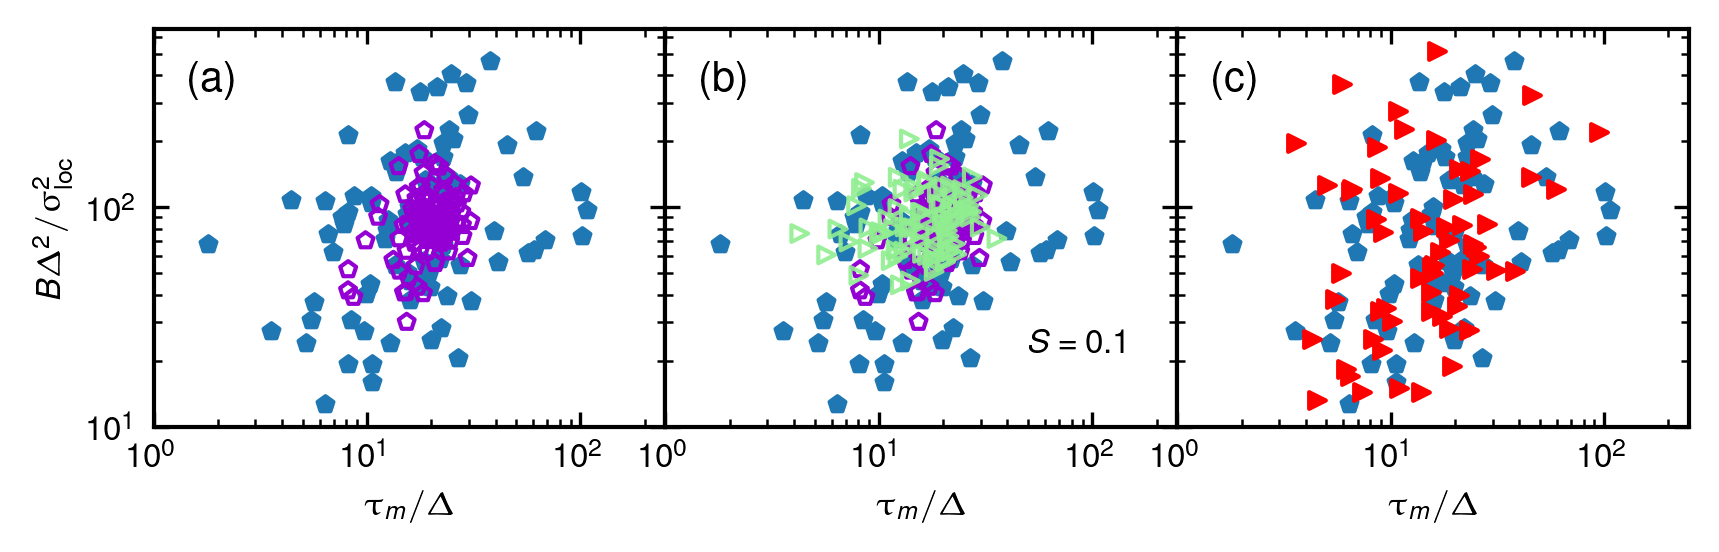

In [47]:
@mpltex.acs_decorator
def plot_test_sim():
    fig, ax = plt.subplots(1, 3, dpi=300)

    ax[0].scatter(distr_exp2[:, 0], distr_exp2[:, 1] / distr_exp2[:, 2]**2, marker='p')
    ax[0].scatter(distr_orig2[:, 0], distr_orig2[:, 1] / distr_orig2[:, 2]**2, marker='p', facecolor='None', edgecolor='darkviolet')


    ax[2].scatter(distr_exp2[:, 0], distr_exp2[:, 1] / distr_exp2[:, 2]**2, marker='p')
    ax[2].scatter(simulated_distr2_10per[:, 0], simulated_distr2_10per[:, 1] / simulated_distr2_10per[:, 2]**2, marker='>', c='r')

    ax[1].scatter(distr_exp2[:, 0], distr_exp2[:, 1] / distr_exp2[:, 2]**2, marker='p')
    ax[1].scatter(distr_orig2[:, 0], distr_orig2[:, 1] / distr_orig2[:, 2]**2, marker='p', facecolor='None', edgecolor='darkviolet')
    ax[1].scatter(gauss_10per_sim_input[:, 0], gauss_10per_sim_input[:, 1] / gauss_10per_sim_input[:, 2]**2, marker='>', edgecolor='lightgreen', facecolor='None', alpha=0.9)
    

    ax[0].loglog()
    ax[1].loglog()
    ax[2].loglog()

    ax[0].set_xlim(1, 250)
    ax[1].set_xlim(1, 250)
    ax[2].set_xlim(1, 250)

    ax[0].set_ylim(10, 650)
    ax[1].set_ylim(10, 650)
    ax[2].set_ylim(10, 650)

    ax[1].set_yticklabels([])
    ax[2].set_yticklabels([])

    ax[0].set_ylabel(r'$B \Delta^2/\sigma_{\rm{loc}}^2$')
    ax[0].set_xlabel(r'$\tau_m/\Delta$')
    ax[1].set_xlabel(r'$\tau_m/\Delta$')
    ax[2].set_xlabel(r'$\tau_m/\Delta$')

    ax[1].text(50, 22, r'$S=0.1$')

    list_abc = ['(a)', '(b)', '(c)']
    for k in range(3):
        ax[k].text(0.07, 0.87,  list_abc[k],
            horizontalalignment='left',
            verticalalignment='center',
            rotation=0,
            fontsize=10,
            transform=ax[k].transAxes)

    plt.subplots_adjust(wspace=0, hspace=0.2, right=1.7, top=0.7)

    plt.show()

plot_test_sim()

# Goodness of fit value R^2 distribution

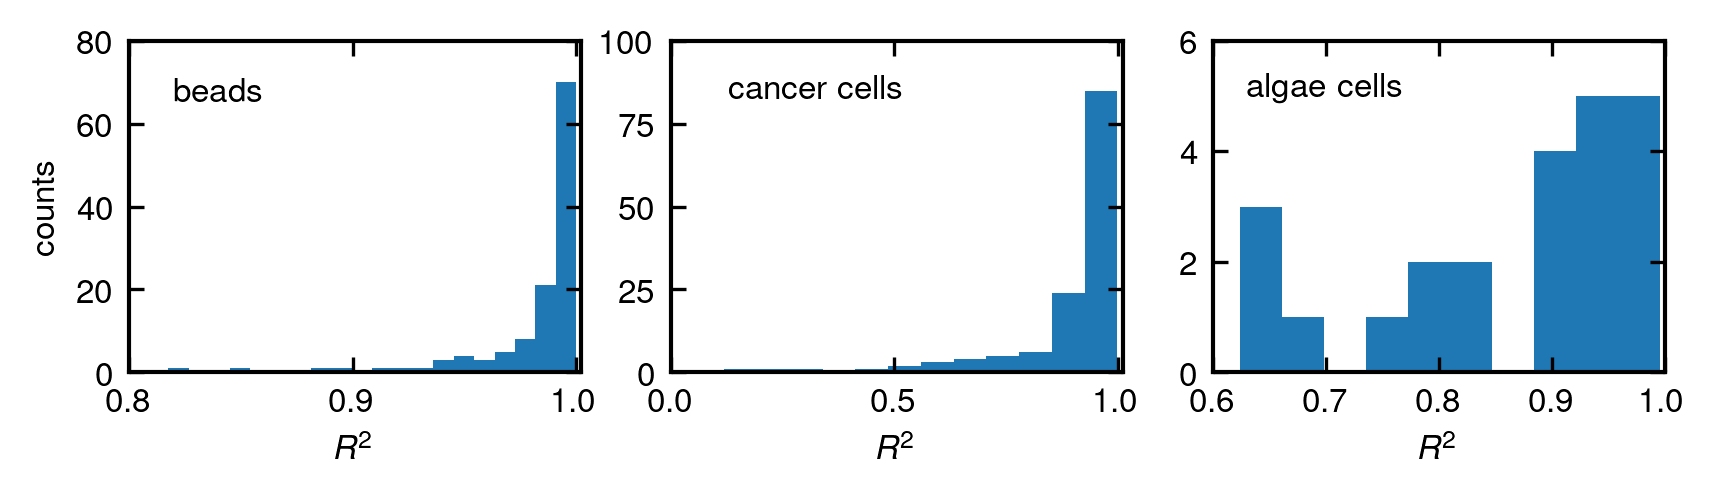

In [48]:
@mpltex.acs_decorator
def plot_rsq_hist():
    fig, ax = plt.subplots(1, 3, dpi=300)

    ax[0].hist(rsq_beads, bins=20)

    # ax[1].hist(np.abs(rsq_mb231), bins=20)
    ax[1].hist(rsq_mb231, bins=20) #filt_mb231

    ax[2].hist(rsq_syn)

    ax[0].set_ylabel(r'$\rm{counts}$')
    ax[0].set_xlabel(r'$R^2$')
    ax[1].set_xlabel(r'$R^2$')
    ax[2].set_xlabel(r'$R^2$')

    # ax[1].set_ylim(0, 63)

    ax[0].set_xlim(0.8, 1.002)
    ax[1].set_xlim(0, 1.01)
    # ax[2].set_xlim(0.8, 1.01)

    ax[0].text(0.82, 65.5, r'$\rm{beads}$')
    ax[1].text(0.13, 83, r'$\rm{cancer}$ $\rm{cells}$')
    ax[2].text(0.63, 5, r'$\rm{algae}$ $\rm{cells}$')

    plt.subplots_adjust(wspace=0.2, hspace=0, right=1.7, top=0.6)
    plt.show()

plot_rsq_hist()

# Best fit

0.999973925573267
0.9981917722497354
0.9963556463029638


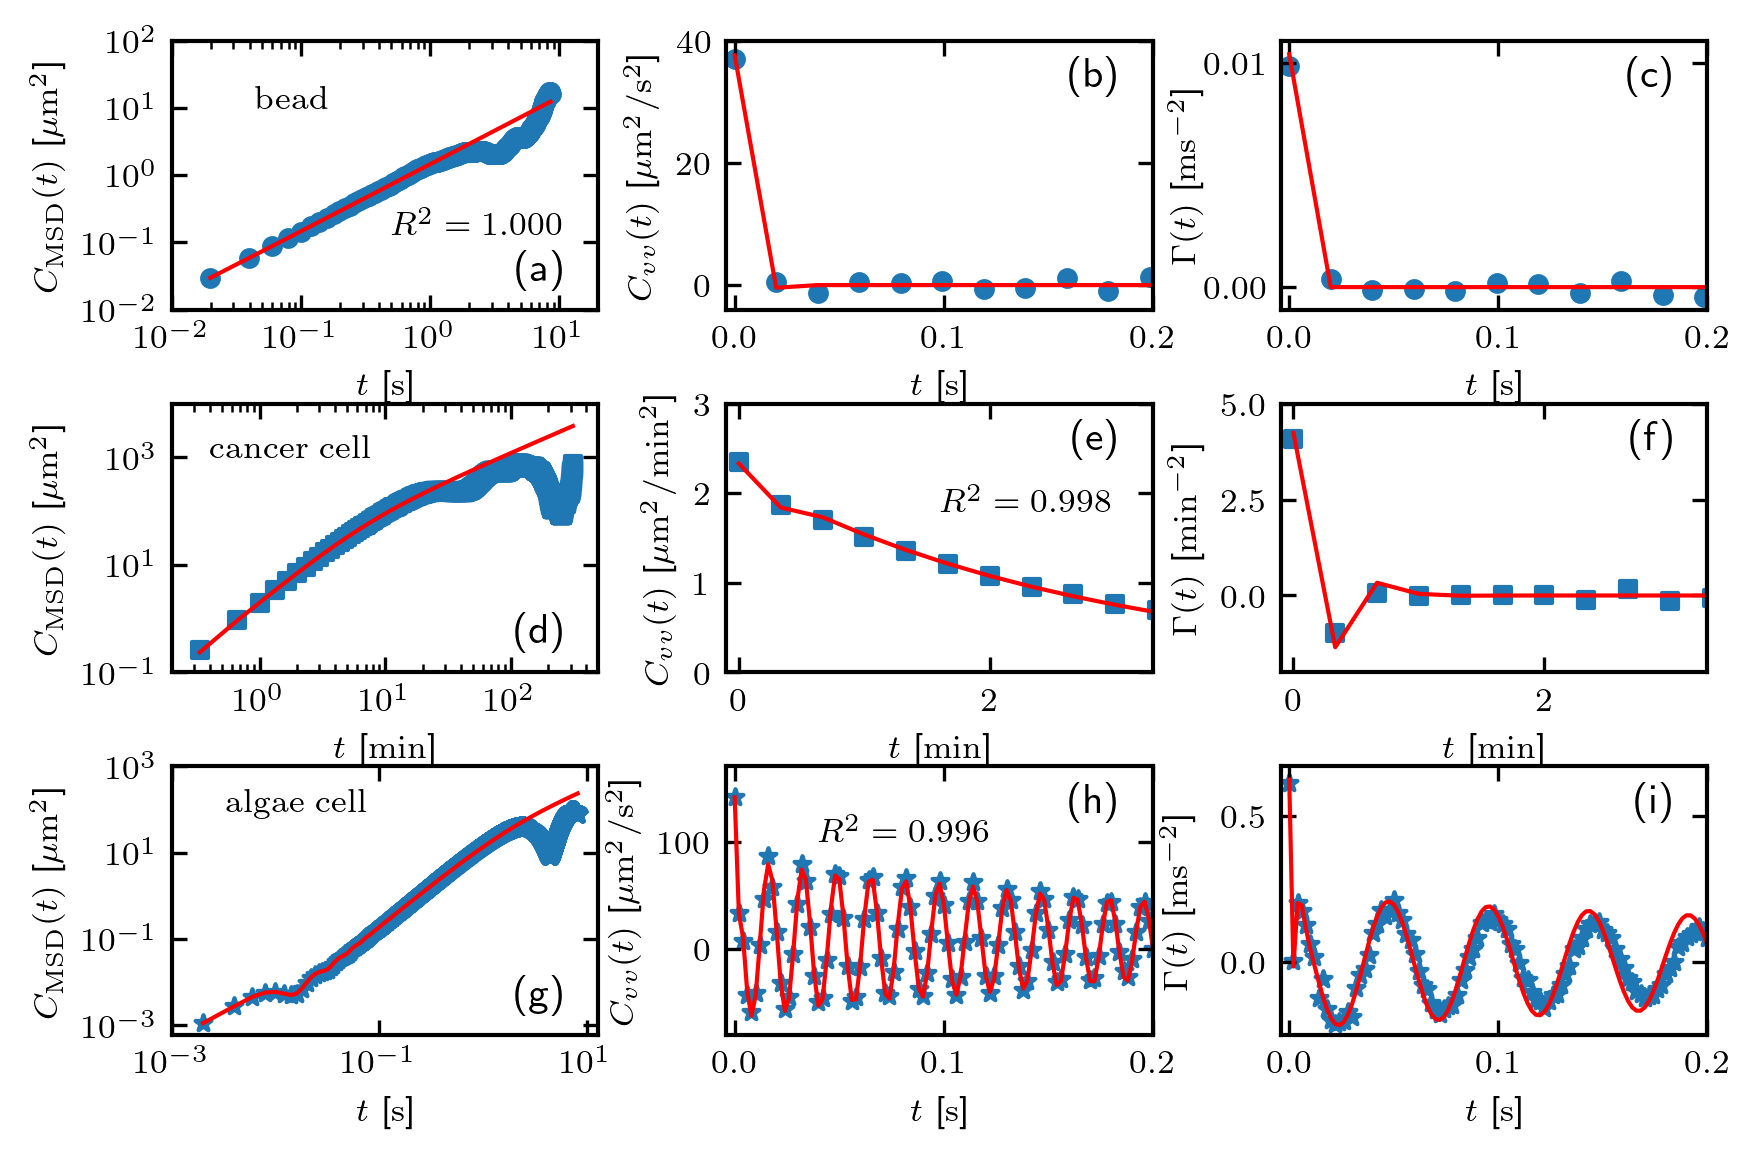

In [49]:
@mpltex.acs_decorator
def plot_msd_vacf_kern_fit():
    fig, ax = plt.subplots(3, 3, dpi=300)
    
    ind_ex = np.argmax(rsq_beads)
    msd_example_beads = dict_1000nm['msd'][filt_inds_beads, :][inds_fd08, :][ind_ex, :].compressed()
    tb = np.arange(len(msd_example_beads)) / 50.41
    ax[0, 0].scatter(tb[1:], msd_example_beads[1:])
    ax[0, 0].plot(tb[1:], 2 * msd_diffusion_noise(*opt_beads_filt[ind_ex, :] , tb)[1:], c='r')
    ax[0, 0].loglog()
    ax[0, 0].set_xlabel(r'$t$ [$\rm{s}$]')
    ax[0, 0].set_ylabel(r'$C_{\rm{MSD}} (t)$ [$\mu \rm{m}^2$]')

    print(rsq_beads[ind_ex])

    vacf_example_beads = 0.5 * (dict_1000nm['cvvx'][filt_inds_beads, :][inds_fd08, :][ind_ex, :].compressed() + dict_1000nm['cvvy'][filt_inds_beads, :][inds_fd08, :][ind_ex, :].compressed())
    ax[0, 1].scatter(tb[:11], vacf_example_beads[:11])
    ax[0, 1].plot(tb[:11], vacf_noise_diffusion(*opt_beads_filt[ind_ex, :] , tb[:12], msd=msd_diffusion), c='r')
    
    ax[0, 1].set_xlabel(r'$t$ [$\rm{s}$]')
    ax[0, 1].set_ylabel(r'$C_{vv} (t)$ [$\mu \rm{m}^2/\rm{s}^2$]')

    kern_example_beads = dict_1000nm['kernel_av'][filt_inds_beads, :][inds_fd08, :][ind_ex, :].compressed()
    ax[0, 2].scatter(tb[:11], 1e-6 * kern_example_beads[:11])
    ax[0, 2].plot(tb[:11], 1e-6 * kernel_1dcc(vacf_noise_diffusion(*opt_beads_filt[ind_ex, :] , tb[:14], msd=msd_diffusion), 1/50.41), c='r')
    
    ax[0, 2].set_xlabel(r'$t$ [$\rm{s}$]')
    ax[0, 2].set_ylabel(r'$\Gamma (t)$ [$\rm{ms}^{-2}$]', labelpad=-0.22)


    ind_ex_opt = np.argmax(rsq_mb231)
    ind_ex = indices_opt_cancer[ind_ex_opt]
    
    tb = np.arange(len(msdx_all20_cut[ind_ex, :].compressed())) / 3
    ax[1, 0].scatter(tb[1:], msdx_all20_cut[ind_ex, 1:].compressed(), marker='s')
    ax[1, 0].plot(tb[1:], msd_prw_noise(*opt_mb231[ind_ex_opt, :] , tb[1:]), c='r')
    ax[1, 0].loglog()
    ax[1, 0].set_xlabel(r'$t$ [$\rm{min}$]')
    ax[1, 0].set_ylabel(r'$C_{\rm{MSD}} (t)$ [$\mu \rm{m}^2$]')

    ax[1, 1].scatter(tb[:11], vacf_all20_cut[ind_ex, :11], marker='s')
    ax[1, 1].plot(tb[:11], vacf_noise_prw(*opt_mb231[ind_ex_opt, :] , tb[:12], msd=msd_prw), c='r')

    ax[1, 1].set_xlabel(r'$t$ [$\rm{min}$]')
    ax[1, 1].set_ylabel(r'$C_{vv} (t)$ [$\mu \rm{m}^2/\rm{min}^2$]')

    print(rsq_mb231[ind_ex_opt])
    
    ax[1, 2].scatter(tb[:11], kernel_all20_cut[ind_ex, :11], marker='s')
    ax[1, 2].plot(tb[:11], kernel_1dcc(vacf_noise_prw(*opt_mb231[ind_ex_opt, :] , tb[:14], msd=msd_prw), 1/3), c='r')

    ax[1, 2].set_xlabel(r'$t$ [$\rm{min}$]')
    ax[1, 2].set_ylabel(r'$\Gamma (t)$ [$\rm{min}^{-2}$]')


    ind_ex_opt = np.argmax(rsq_syn)
    ind_ex = indices_opt_syn[ind_ex_opt] - 1
    vacf_ex = 0.5 * (vxacf_s[ind_ex, :].compressed() + vyacf_s[ind_ex, :].compressed())

    tb = np.arange(len(msds[ind_ex, :].compressed())) / 500
    ax[2, 0].scatter(tb[1:], msds[ind_ex, 1:].compressed(), marker='*')
    ax[2, 0].plot(tb[1:], 2 * msd_noise_osc(*opt_syn[ind_ex_opt, :] , tb, msd=msd_osc_sincos)[1:], c='r')
    ax[2, 0].loglog()
    ax[2, 0].set_xlabel(r'$t$ [$\rm{s}$]')
    ax[2, 0].set_ylabel(r'$C_{\rm{MSD}} (t)$ [$\mu \rm{m}^2$]')

    ax[2, 1].scatter(tb[:101], vacf_ex[:101], marker='*')
    ax[2, 1].plot(tb[:101], vacf_noise_osc(*opt_syn[ind_ex_opt, :] , tb[:102], msd=msd_osc_sincos), c='r')
    ax[2, 1].set_xlabel(r'$t$ [$\rm{s}$]')
    ax[2, 1].set_ylabel(r'$C_{vv} (t)$ [$\mu \rm{m}^2/\rm{s}^2$]')

    print(rsq_syn[ind_ex_opt])
    
    ax[2, 2].scatter(tb[:101], 1e-6 * kernel_av_s[ind_ex, :101], marker='*')
    ax[2, 2].plot(tb[:101], 1e-6 * kernel_1dcc(vacf_noise_osc(*opt_syn[ind_ex_opt, :] , tb[:104], msd=msd_osc_sincos), 0.002), c='r')
    ax[2, 2].set_xlabel(r'$t$ [$\rm{s}$]')
    ax[2, 2].set_ylabel(r'$\Gamma (t)$ [$\rm{ms}^{-2}$]')
    ax[2, 2].get_yaxis().set_label_coords(-0.2, 0.5)

    ax[0, 0].set_yticks([0.01, 0.1, 1, 10, 100])
    ax[0, 2].set_yticks([0, 0.01])

    ax[1, 0].set_xticks([1, 10, 100])
    ax[2, 0].set_yticks([0.001, 0.1, 10, 1000])

    ax[2, 2].set_ylim(-0.25, 0.67)
    ax[2, 2].set_xlim(-0.004, 0.2)

    ax[2, 1].set_ylim(-80, 170)
    ax[2, 1].set_xlim(-0.004, 0.2)

    ax[2, 0].set_ylim(6e-4, 1000)


    ax[0, 0].set_xlim(0.01, 20)
    ax[1, 0].set_xlim(0.2, 500)
    ax[2, 0].set_xlim(1e-3, 13)

    ax[1, 1].set_xlim(-0.1, 3.3)
    ax[1, 1].set_ylim(0, 3)
    ax[1, 2].set_xlim(-0.1, 3.3)
    ax[1, 2].set_ylim(-2, 5)

    ax[0, 1].set_ylim(-4, 40)
    ax[0, 1].set_xlim(-0.004, 0.2)

    ax[0, 2].set_ylim(-1e-6 * 1000, 1e-6 * 11000)
    ax[0, 2].set_xlim(-0.004, 0.2)

    ax[0, 0].text(0.044, 10, r'$\rm{bead}$')
    ax[1, 0].text(0.4, 1000, r'$\rm{cancer}$ $\rm{cell}$')
    ax[2, 0].text(0.0033, 90, r'$\rm{algae}$ $\rm{cell}$')

    k = 0
    for i in range(3):
        for j in range(3):
            if j == 0:
                ax[i, j].text(0.93, 0.15, '(' + alphabet[k] + ')',
                    horizontalalignment='right',
                    verticalalignment='center',
                    rotation=0,
                    fontsize=10,
                    transform=ax[i, j].transAxes)
            else:
                ax[i, j].text(0.93, 0.87, '(' + alphabet[k] + ')',
                    horizontalalignment='right',
                    verticalalignment='center',
                    rotation=0,
                    fontsize=10,
                    transform=ax[i, j].transAxes)
            k += 1
    
    ax[0, 0].text(0.5, 0.13, r'$R^2=1.000$')
    ax[1, 1].text(1.6, 1.8, r'$R^2=0.998$')
    ax[2, 1].text(0.04, 100, r'$R^2=0.996$')

    plt.subplots_adjust(wspace=0.3, hspace=0.35, right=1.7, top=1.6)

plot_msd_vacf_kern_fit()
plt.show()

# Histogram bead radii

0.5108579596988636 0.016622188116964552 0.01985427980607467 0.016815811654967754


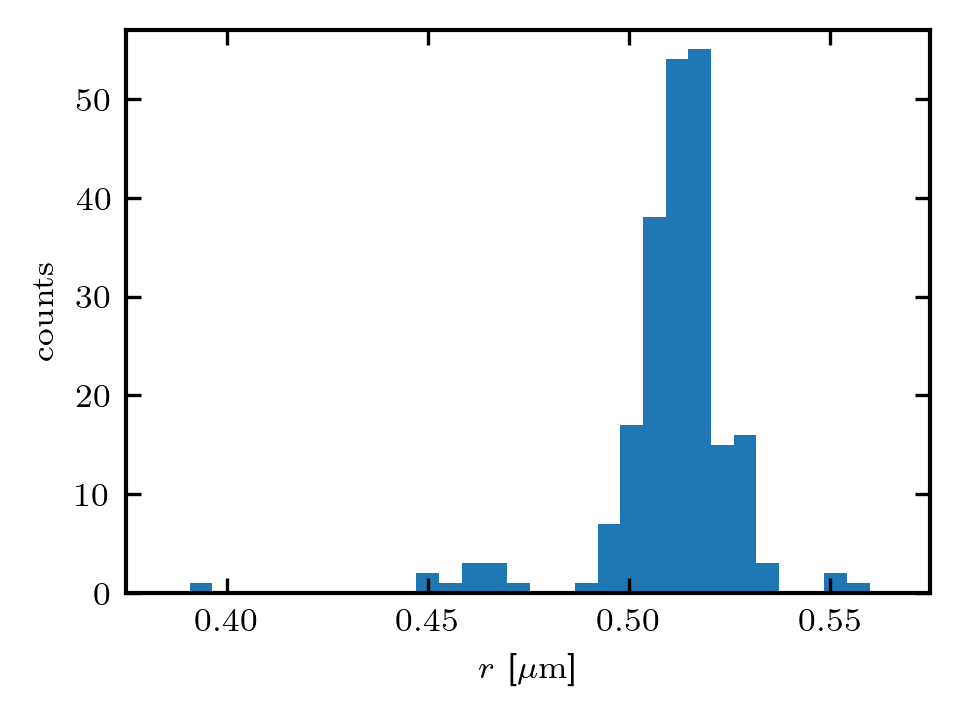

In [50]:
@mpltex.acs_decorator
def plot_msd_vacf_kern_fit():
    fig, ax = plt.subplots(1, 1, dpi=300)
    radii = np.array(np.loadtxt('radii_beads_afm.txt')) * 1e6/2
    ax.hist(radii, bins=30)
    # print(np.std(radii), radii)
    ax.set_xlabel(r'$r$ [$\mu \rm{m}$]')
    ax.set_ylabel(r'$\rm{counts}$')
    ax.set_xlim(0.75/2, 1.15/2)
    ax.set_ylim(0, 57)
    print(np.mean(radii), np.std(radii), np.sqrt(np.sum((radii - 1/2)**2)/len(radii)), np.sqrt(np.sum((radii - np.median(radii))**2)/len(radii)))

plot_msd_vacf_kern_fit()

plt.show()